<img src="https://www.hydroshare.org/resource/8e2fa6f38ce142e09fa1eb999cd5f248/data/contents/iguide_logo.png" width=200 height=200 />

# Examining Hydrological Responses and Shrinkage in the Great Salt Lake

**Authors**: Irene Garousi-Nejad <igarousi@cuahsi.org>, Kat Fowler <kff26@nau.edu>, Mallory Jordan <maj0062@auburn.edu>, Hodo Orok <horok2@illinois.edu>, Marian de Orla-Barile <mariandeorla-barile@ucsb.edu>, Daniel Beene <darbeene@salud.unm.edu>, Yen-Yi Wu <ywu10@uwyo.edu>

**Last Updated**: 09.11.2023

**What does this notebook do?**

This notebook allows you to perform a set of **four analyses** to explore hydrologic drivers of changes in the Great Salt Lake. Most of these analyses focus on the National Water Model (NWM) from the National Oceanic and Atmospheric Administration (NOAA) as there is currently an effort to make the NWM more robust for predicting water supply. Water managers in the Great Salt Lake are interested in understanding the water balance of the basin, and the NWM plays a crucial role in this effort.    

> - <font color='blue'> **Analysis I** </font>: We compare the NWM input precipitation dataset, obtained from the Analysis of Record for Calibration (AORC version 1.0) dataset, with a commonly used precipitation dataset in hydrological studies called PRISM across the three watersheds feeding into the Great Salt Lake. This exercise attempts to assess both how short-term averages for the Great Salt Lake compare to long-term averages, and how AORC might be performing compared to PRISM. (<font color='red'> Look at Step 1 and Step 2 </font>)
> - <font color='blue'> **Analysis II** </font>: We compare NWM simulated streamflow to observations from the United States Geological Survey (USGS). (<font color='red'> Look at Step 3 and Step 4 </font>)
> - <font color='blue'> **Analysis III** </font>: We compare cumulative precipitation and runoff, accumulated from October 1 through September 30 for each water year, between AORC and PRISM, as well as NWM and USGS, for the water years 2016-2019. The second and third analyses explore how accurately the NWM can predict water supply in the main tributaries to the Great Salt Lake, and how that relates to the input precipitation dataset. 
> - <font color='blue'> **Analysis IV** </font>: We use Landsat data to create a numerical time series and a visualization of how the area of the Great Salt Lake has changed between 1984-2022.

**Notes on code and system requirements**: This notebook summarizes work performed at the I-GUIDE Summer School 2023 by Team 4, comprised of team lead Dr. Irene Garousi-Nejad and participants listed under Authors. We intend this to be set up as a lesson that is reusable on the I-GUIDE platform by using APIs to pull datasets and conducting the computational steps using computational resources being avaible by the IGUIDE platfrom and computational resources. We download packages to the operating system and import them into Python as needed, but it does assume we are uisng the **`conda env:iguide`** kernel for the Jupyter notebook as it was configured at the time of the last update.

Since the code is reusable, a user does not *need* prior experience with Python, but it will be most useful for people who have seen Python code before. Some cells use bash (i.e., the Linux-based language you use to interact with your operating system) instead. We make note of this in comments (comments are all preceded by a "#" so the system doesn't read them as code). Some familiarity with bash is useful but not necessary, since it is a minor part of the code. There is one javascript code block at the end of the notebook that you can copy/paste into Google Earth Engine to recreate the GIF image we use to show shrinkage in the Great Salt Lake.

**Notes on what Team 4 needs to complete before October**: We used AORC 5-year average for the AORC vs. PRISM comparison and alluded to using PRISM daily data to calculate the 5-year average in future work. We ended up downloading the PRISM daily data throughout the week and were able to use it in our 3rd analysis. We need to go back and do AORC 5-year vs. PRISM 5-year, and PRISM 5-year vs. PRISM 30-year. We also need to double-check that our use of RMSE (especially the two groups) is valid in the 3rd analysis. We could also incorporate more ethical dimensions into the markdown cells.

---

# Study Area and Motivation

In the northwestern corner of Utah, sits the Great Salt Lake, the largest saltwater lake in the western hemisphere and eighth largest in the world. This lake is fed primarily by surface runoff from rain and snowmelt in the Bear, Weber, and Jordan-Provo River watersheds. No rivers drain from the lake, meaning that the only outlet is evaporation. Because of this, the lake has become incredibly saline, resulting in a crucial ecosystem for migratory birds who feed on brine shrimp and brine flies, as well as important industries like salt production and food processing for aquaculture. Today, the Great Salt Lake faces a crisis as levels are rapidly declining, threatening ecologic and economic vitality, and increasing the potential of human health risks associated with inhaling newly exposed dust carrying increased levels of toxic metal mixtures (ATSDR 2023; Thorsen et al., 2017).




<center><img src="https://www.hydroshare.org/resource/8e2fa6f38ce142e09fa1eb999cd5f248/data/contents/study-site.png" width=500 height=500 /></center>

**References**:

- (ATSDR) Agency for Toxic Substances and Disease Registry. (2023, March 17). Substance Priority List. https://www.atsdr.cdc.gov/spl/index.html
- Thorsen, M. L., Handy, R. G., Sleeth, D. K., Thiese, M. S., & Riches, N. O. (2017). A comparison study between previous and current shoreline concentrations of heavy metals at the Great Salt Lake using portable X-ray fluorescence analysis. Human and Ecological Risk Assessment: An International Journal, 23(8), 1941–1954. https://doi.org/10.1080/10807039.2017.1349541


---

# Import required libraries to run this notebook

In [3]:
# use bash to install some necessary packages in your Jupyter system
# the ! notation tells the system to read the following command as bash and not Python notation
# make sure the kernel is set to conda env: iguide
# this will take ~1 minute
!pip install cartopy --quiet
!pip install rasterstats --quiet
!pip install geopandas --quiet
!pip install unzip --quiet
!pip install hsclient --quiet
!pip install s3fs --quiet
!pip install zarr --quiet
!pip install openpyxl --quiet
!mamba install unzip --y --quiet
!pip install dataretrieval --quiet

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [4]:
# this code block is unnecessary, but we use it to suppress warnings when importing the packages in the code block below to the Python kernel
# if you want to see the warnings (dependency conflicts, etc) you can remove this block
import warnings
warnings.filterwarnings('ignore')

In [5]:
# import all the libraries we'll need across the analyses

# entire libraries
#----------------------------------------------------------------------------------------------------------------------
import os
import subprocess
import fsspec
import shutil
import zipfile
import glob
import re
import dask

import pandas as pd
import numpy as np
import rasterio as rio
import xarray as xr

# specific functions
#----------------------------------------------------------------------------------------------------------------------
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.dates as mdates

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from matplotlib.ticker import ScalarFormatter
from rasterstats import zonal_stats
from hsclient import HydroShare
from geopandas import GeoSeries, GeoDataFrame, read_file, gpd
from shapely.geometry import MultiPolygon
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from matplotlib import colors
from dask.distributed import Client
from dask.distributed import progress
from dataretrieval import nwis
from IPython.display import display
from matplotlib import ticker

# <font color='blue'> **Analysis I.** </font> Compare the input precipitation data from the National Weather Model sourced from AORC with PRISM data for the three watersheds

<div style="background-color: whitesmoke; padding: 10px; box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.2); color: #333;">

This analysis compares the precipitation product that was used as an input to the NWM retrospective simulations to another commonly used precipitation product, called PRISM. The point of this exercise is to determine how comparable the AORC precipitation data is with other datasets.  

</div>



The first analysis includes two main steps:  <b/>

**Step 1**. Prepare the spatially averaged PRISM precipitation data for each watershed
> 1.1 Download PRISM monthly normals precipitation data \
> 1.2 Use consistent projections \
> 1.3 Subset data and calculate spatial average of the PRISM precipitation across each watershed.  \
> 1.4 Plot a time series of 30-year average precipitation for one watershed


**Step 2**. Prepare the spatially averaged AORC precipitation data for each watershed
> 2.1. Import the AORC forcing dataset and aggregate to monthly and daily values\
> 2.2.  Plot PRISM vs. AORC 


<div class="alert alert-block alert-success">
<b> Delving Deeper: Before delving into the detailed explanations of Step 1 and Step 2, let's first explore and understand the geographical domain of our watershed. This understanding will lay the foundation for calculating the spatial average precipitation.  </b> 

</div>

In this first section, we'll illustrate some features of one of our watersheds of interest, the <font color='blue'> Weber River </font>. We won't use any of the outputs from this section for later analysis, but it will introduce you to some hydrological concepts and spatial analysis concepts that will be useful for later sections.

First, we download shapefiles for plotting, which we stored in a [Hydroshare repository](https://www.hydroshare.org/resource/8e2fa6f38ce142e09fa1eb999cd5f248/) to make them persistently available for this analysis. You will need a Hydroshare account to access the files, but it's free to sign up! Make sure you have your username and password on hand. The section below uses the [HydroShare Python Client Library](https://www.hydroshare.org/resource/7561aa12fd824ebb8edbee05af19b910/) (**`hsclient`**) to retrieve the data from the Hydroshare resource containing our data.

In [15]:
# initiate access to the Hydroshare API
# this will ask for your username and password
hs = HydroShare()
hs.sign_in()

Username:  kat-ffowler
Password for kat-ffowler:  ········


In [16]:
# specify the resource you want to download by its unique Hydroshare ID - we have already filled this in for you
# this can take a few minutes and will output the name of a .zip file as a string
res = hs.resource('8e2fa6f38ce142e09fa1eb999cd5f248')
res.download()

'8e2fa6f38ce142e09fa1eb999cd5f248.zip'

In [17]:
# use bash to unzip the files
# the -q flag means "quiet" so we don't print the very long output, but you can remove it to see all the files that are being unzipped
!unzip -q 8e2fa6f38ce142e09fa1eb999cd5f248.zip

You should see a new folder in your working directory now. Your data are in `8e2fa6f38ce142e09fa1eb999cd5f248/8e2fa6f38ce142e09fa1eb999cd5f248/data/contents/`.

Now we'll use the Python libraries `MultiPolygon`, `Shapely`, and `Matplotlib` to format and plot some of the spatial data we've downloaded.

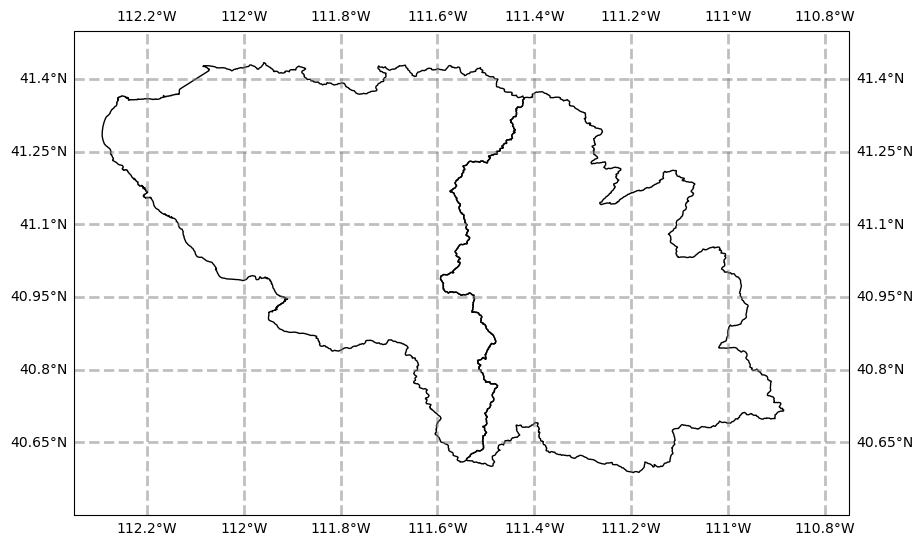

In [18]:
# path to the data
data_path = "./8e2fa6f38ce142e09fa1eb999cd5f248/data/contents/GISBasins/catchment"

# select the shapefile for the Weber River watershed
mp = MultiPolygon(Reader(os.path.join(data_path, 'WeberRiverBasin.shp')).geometries())

# read the geometries for plotting
shape_feature = ShapelyFeature(mp.geoms,
                                ccrs.PlateCarree(), facecolor='none')

# visualize data on the map
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

shape_feature = ShapelyFeature(mp.geoms,
                                ccrs.PlateCarree(), facecolor='none')
ax.add_feature(shape_feature, zorder=1)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--');

# modify the x and y limits based on the watershed's bounding box information
ax.set_ylim([40.5, 41.5]);
ax.set_xlim([-112.35, -110.75]);
ax.set_aspect('equal');
ax.coastlines();

What you're seeing in the plot above are the two "HUC8" watersheds that the Weber River flows through. HUC stands for Hydrologic Unit Code and is a standard nested system to define watershed boundaries. The more digits defining a HUC code (e.g., 2, 4, 6, 8), the smaller the unit. Each HUC8, for example, is nested within a particular HUC6 watershed, which is nested within a HUC4 watershed, and so on. [Here](https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/images/huc_visual_final.png) is a graphic from the USGS that helps define it.

Our data are at HUC8 resolution. We want to calculate spatially averaged precipitation across the drainage areas for each of our three rivers of interest. To do that, we need to "dissolve" the HUC8 units into a single unit. The spatial analysis function `zonal_stats` from the `rasterstats` package we use later does this internally, but we want to perform this function manually and plot the output to get an understanding of what is happening.

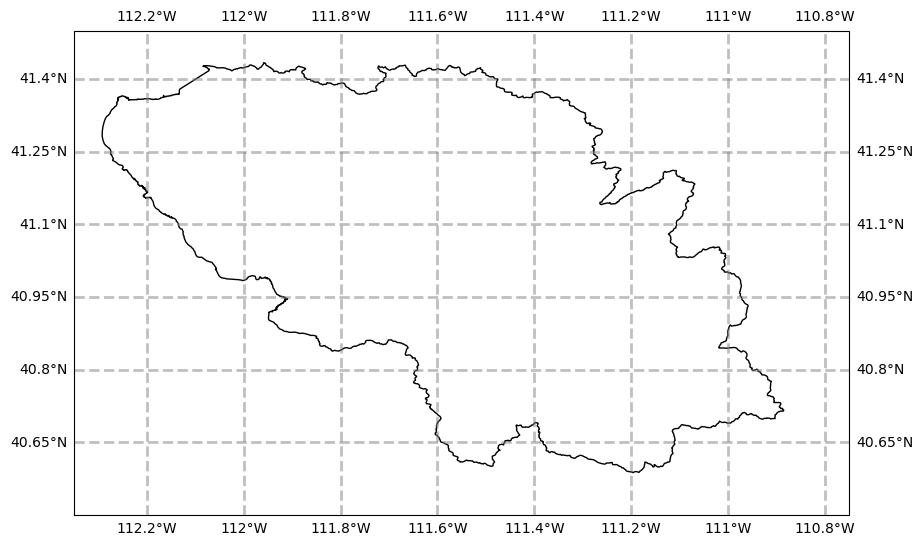

In [19]:
# re-read the Weber River shapefile as a dataframe
watershed = read_file(os.path.join(data_path, 'WeberRiverBasin.shp'))

# add a column with a constant value that will be used to dissolve the shapefile
watershed['temp']=1

# dissolve
watershed_dis = watershed.dissolve(by = 'temp', aggfunc = 'sum')

# read the geometries for plotting
shape_feature = ShapelyFeature(watershed_dis.geometry,
                                ccrs.PlateCarree(), facecolor='none')

# visualize data on the map
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

shape_feature = ShapelyFeature( watershed_dis.geometry,
                                ccrs.PlateCarree(), facecolor='none')
ax.add_feature(shape_feature, zorder=1)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--');

# modify the x and y limits based on the watershed's bounding box information
ax.set_ylim([40.5, 41.5]);
ax.set_xlim([-112.35, -110.75]);
ax.set_aspect('equal');
ax.coastlines();

Now you can see we only have one geometry for the Weber River, instead of the two HUC8 units. Again, `zonal_stats` will do this for us for each watershed, but now we understand what is happening "under the hood."

<div class="alert alert-block alert-info">
<b> NOTE: </b> Note that the watersheds we're analyzing (the Bear, Weber, and Jordan-Provo rivers) have a different number of relevant HUC8 units. The Bear River has seven HUC8s included, while the Jordan-Provo River has three and Weber River has two HUC8 units. We are going to do separate analyses for each river. In geospatial analysis, we often think about the Modifiable Areal Unit problem, which says that spatial statistics you derive at one scale are not valid at other scales, so the resolution of your analysis matters. If you wanted to dissolve the watersheds for all 3 rivers into one big geometry representing all the inflow into the Great Salt Lake, or otherwise statistically compare these three watersheds, you would need to be cautious that they comprise a different number of HUC8s and that can affect the results of your analyses. </b>
</div>

## 1.1. Download PRISM Monthly Normals Precipitation Data

Now we'll download precipitation data from the PRISM dataset from their web service so we can calculate spatially averaged precipitation over each of the three river catchments. PRISM Climate Group collects climate observations "from a wide range of monitoring networks, applies sophisticated quality control measures, and develops spatial climate datasets to reveal short- and long-term climate patterns." Their precipitation datasets are widely used in hydrology. We download 30-year average precipitation conditions across the continental US (CONUS) for each month from their **"monthly normals"** dataset. You can find out more about it here: https://prism.oregonstate.edu/normals/

PRISM provides a single file per request, and we have one request per month. The files we're requesting are in BIL format. BIL means “band interleaved by line" and is an uncompressed file containing the actual pixel values of an image. Run the following bash script to perform a bulk download of multiple BIL files.

The script creates a folder called PRISM_monthly_normals to store the results (if it does not already exist in your working directory). Then we print just the names of the files that we want to download to check what's available. Lastly, the code retrieves a file for each month, *_bil.zip, and saves them in PRISM_monthly_normals. The last block unzips the zip files using bash and Python.

In [20]:
%%bash
# this entire cell block is written in bash, so instead of using the ! notation from before, we tell Jupyter
# to read the whole cell as a bash script using "%%"

# define the folder name
folder="./PRISM_monthly_normals"

# check if the folder already exists or not
if [ ! -d "$folder" ]; then
    mkdir -p "$folder"
    echo "Directory created: $folder"
else
    echo "Directory already exists: $folder"
fi

Directory created: ./PRISM_monthly_normals


In [21]:
%%bash

for m in {01..12};do #for loop from jan-dec because these are monthly data (doesn't load)
    echo https://ftp.prism.oregonstate.edu/normals_800m/ppt/PRISM_ppt_30yr_normal_800mM4_${m}_bil.zip
done

https://ftp.prism.oregonstate.edu/normals_800m/ppt/PRISM_ppt_30yr_normal_800mM4_01_bil.zip
https://ftp.prism.oregonstate.edu/normals_800m/ppt/PRISM_ppt_30yr_normal_800mM4_02_bil.zip
https://ftp.prism.oregonstate.edu/normals_800m/ppt/PRISM_ppt_30yr_normal_800mM4_03_bil.zip
https://ftp.prism.oregonstate.edu/normals_800m/ppt/PRISM_ppt_30yr_normal_800mM4_04_bil.zip
https://ftp.prism.oregonstate.edu/normals_800m/ppt/PRISM_ppt_30yr_normal_800mM4_05_bil.zip
https://ftp.prism.oregonstate.edu/normals_800m/ppt/PRISM_ppt_30yr_normal_800mM4_06_bil.zip
https://ftp.prism.oregonstate.edu/normals_800m/ppt/PRISM_ppt_30yr_normal_800mM4_07_bil.zip
https://ftp.prism.oregonstate.edu/normals_800m/ppt/PRISM_ppt_30yr_normal_800mM4_08_bil.zip
https://ftp.prism.oregonstate.edu/normals_800m/ppt/PRISM_ppt_30yr_normal_800mM4_09_bil.zip
https://ftp.prism.oregonstate.edu/normals_800m/ppt/PRISM_ppt_30yr_normal_800mM4_10_bil.zip
https://ftp.prism.oregonstate.edu/normals_800m/ppt/PRISM_ppt_30yr_normal_800mM4_11_bil.zip

In [22]:
%%bash

# for each month (in 2-digit notation, e.g., 01 for January, 02 for February...), download the PRISM data
for m in {01..12};do
    echo "Downloading data for Month: $m"
    url="https://ftp.prism.oregonstate.edu/normals_800m/ppt/PRISM_ppt_30yr_normal_800mM4_${m}_bil.zip"
    wget -q "$url" -P ./PRISM_monthly_normals
    sleep 4
done

In [23]:
%%bash

# now we need to unzip the files, so we set the filepath for the folder the PRISM files are in
folder="./PRISM_monthly_normals"

# loop through the PRISM files and unzip each one (but suppress output with -q)
for file in "$folder"/*.zip; do
    unzip -q "$file" -d "$folder"
done

You should see a lot of files in your PRISM_monthly_normals folder now.

Let's visualize the precipitation data for a single month to see what we're working with. The code bock below uses the Python library rasterio to import the data for January. We use Matplotlib to plot the map, with different colors for different ranges of precipitation in millimeters (mm). You can change the bounds of precipitation included in each color category in the line `bounds=[0, 50, 100, 200, 600, img_precip[0].max()]`.

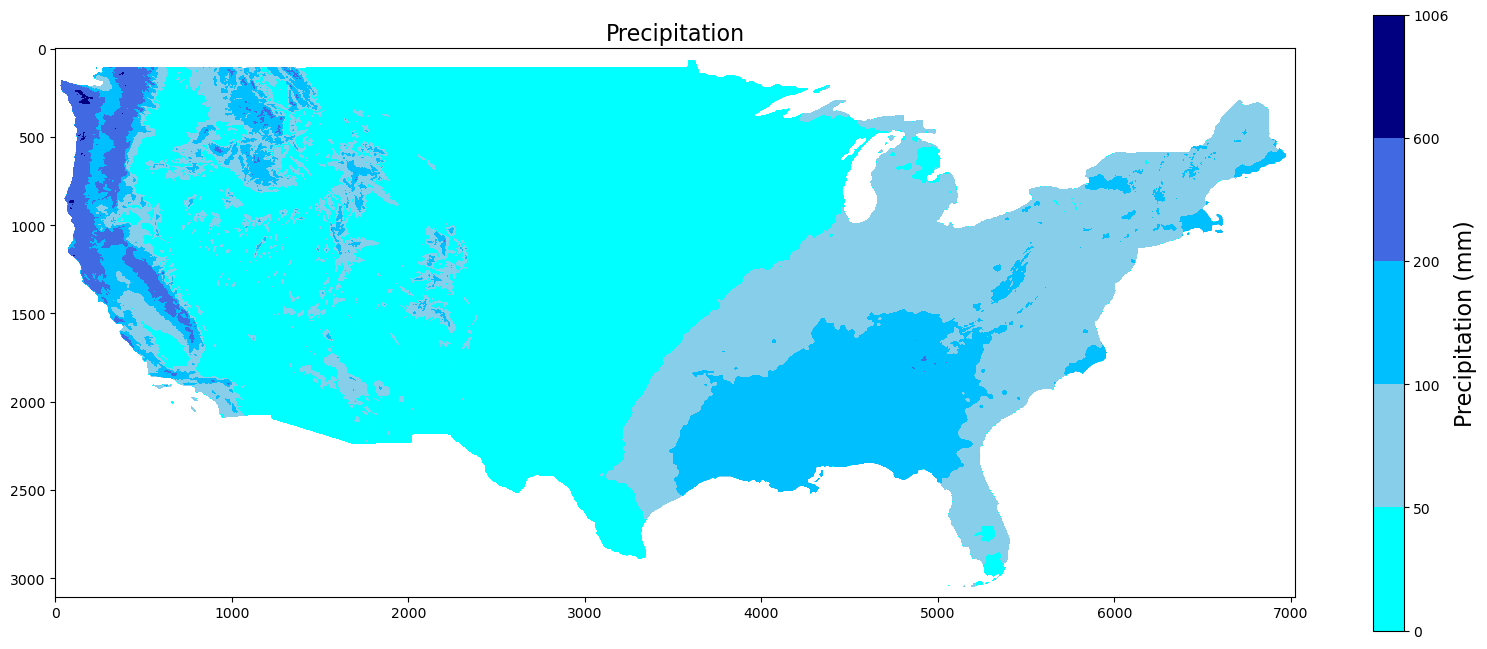

In [24]:
# use rasterio to import the data as img
with rio.open("./PRISM_monthly_normals/PRISM_ppt_30yr_normal_800mM4_01_bil.bil") as src:
    boundary = src.bounds
    img_precip = src.read()
    nodata = src.nodata

# plot
plt.figure(figsize=(20,8))
plt.title("Precipitation", size=16)
cmap = colors.ListedColormap(['cyan', 'skyblue', 'deepskyblue', 'royalblue', 'navy'])
cmap.set_under('w')
bounds=[0, 50, 100, 200, 600, img_precip[0].max()]
norm = colors.BoundaryNorm(bounds, cmap.N)
imgplot = plt.imshow(img_precip[0], cmap=cmap, norm=norm)
cbar = plt.colorbar()
cbar.set_label('Precipitation (mm)', size=16)

plt.show()

As you might expect, we see more precipitation in the Pacific Northwest and in the Southeast, while there is relatively very little precipitation across the Intermountain West. For our time series analysis we'll subset the data to just our watersheds of interest.

## 1.2. Use consistent projections

As is often the case with GIS, there is a need to have consistent coordinate projections. GDAL and OGR are both translation libraries for raster and geospatial data formats and provide many useful, widely-used geospatial analysis tools.

The following GDAL and OGR command examines the projections of the precipitation data and shapefile, respectively. Each command prints a lot of metadata, but the line we're interested in for both begins with "ID[...]". This is where we see what projection is used. For the PRISM data, it's **ESPG #6269**, but for the shapefile of the river basin it's **ESPG #4269**.

If you're familiar with projection information, you might notice that the UNIT is "Degree", and the Pixel Size is 0.008333333333333 degree. This is because we haven't projected the data yet, so it only has a geographic coordinate system.

In [25]:
# check the projection information of the PRISM data
!gdalinfo -proj4 ./PRISM_monthly_normals/PRISM_ppt_30yr_normal_800mM4_01_bil.bil

Driver: EHdr/ESRI .hdr Labelled
Files: ./PRISM_monthly_normals/PRISM_ppt_30yr_normal_800mM4_01_bil.bil
       ./PRISM_monthly_normals/PRISM_ppt_30yr_normal_800mM4_01_bil.bil.aux.xml
       ./PRISM_monthly_normals/PRISM_ppt_30yr_normal_800mM4_01_bil.hdr
       ./PRISM_monthly_normals/PRISM_ppt_30yr_normal_800mM4_01_bil.stx
       ./PRISM_monthly_normals/PRISM_ppt_30yr_normal_800mM4_01_bil.prj
Size is 7025, 3105
Coordinate System is:
GEOGCRS["NAD83",
    DATUM["North American Datum 1983",
        ELLIPSOID["GRS 1980",6378137,298.257222101,
            LENGTHUNIT["metre",1]],
        ID["EPSG",6269]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["Degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["longitude",east,
            ORDER[1],
            ANGLEUNIT["Degree",0.0174532925199433]],
        AXIS["latitude",north,
            ORDER[2],
            ANGLEUNIT["Degree",0.0174532925199433]]]
Data axis to CRS axis mapping: 1,2
PROJ.4 string is:
'+proj=longlat +datum=NAD83 +no

In [26]:
# check the projection information for the watershed shapefile (we pipe this into the "head" command so we only see the metadata rows)
!ogrinfo -al ./8e2fa6f38ce142e09fa1eb999cd5f248/data/contents/GISBasins/catchment/WeberRiverBasin.shp | head -n56

INFO: Open of `./8e2fa6f38ce142e09fa1eb999cd5f248/data/contents/GISBasins/catchment/WeberRiverBasin.shp'
      using driver `ESRI Shapefile' successful.

Layer name: WeberRiverBasin
Metadata:
  DBF_DATE_LAST_UPDATE=2023-07-24
Geometry: Polygon
Feature Count: 2
Extent: (-112.292212, 40.587602) - (-110.885218, 41.433791)
Layer SRS WKT:
GEOGCRS["NAD83",
    DATUM["North American Datum 1983",
        ELLIPSOID["GRS 1980",6378137,298.257222101,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4269]]
Data axis to CRS axis mapping: 2,1
OBJECTID: Real (20.0)
TNMID: String (40.0)
MetaSource: String (40.0)
SourceData: String (100.0)
SourceOrig: String (130.0)
SourceFeat: String (40.0)
Load

Now that we know the projection of the shapefile, we can remap the PRISM data using the correct projection. We use the **`gdalwarp`** function to assign the projection of the shapefile to each of the PRISM files. We create a new directory to store these results (unless something with the same name already exists, e.g. you ran this notebook previously) and loop through all the PRISM files.

In [27]:
# get a list of all .bil files in the folder
bil_files = [file for file in os.listdir("./PRISM_monthly_normals") if file.endswith('.bil')]
bil_files

['PRISM_ppt_30yr_normal_800mM4_09_bil.bil',
 'PRISM_ppt_30yr_normal_800mM4_01_bil.bil',
 'PRISM_ppt_30yr_normal_800mM4_06_bil.bil',
 'PRISM_ppt_30yr_normal_800mM4_07_bil.bil',
 'PRISM_ppt_30yr_normal_800mM4_05_bil.bil',
 'PRISM_ppt_30yr_normal_800mM4_08_bil.bil',
 'PRISM_ppt_30yr_normal_800mM4_10_bil.bil',
 'PRISM_ppt_30yr_normal_800mM4_12_bil.bil',
 'PRISM_ppt_30yr_normal_800mM4_04_bil.bil',
 'PRISM_ppt_30yr_normal_800mM4_02_bil.bil',
 'PRISM_ppt_30yr_normal_800mM4_03_bil.bil',
 'PRISM_ppt_30yr_normal_800mM4_11_bil.bil']

In [28]:
%%bash

# we're using bash to create a file for the re-mapped PRISM data if it does not already exist
# define the folder name
folder="./PRISM_monthly_normals/outputs"

# check if the folder already exists or not
if [ ! -d "$folder" ]; then
    mkdir -p "$folder"
    echo "Directory created: $folder"
else
    echo "Directory already exists: $folder"
fi

Directory created: ./PRISM_monthly_normals/outputs


In [29]:
# set the filepaths for your input and output folders (output folder was created above if necessary)
input_folder = './PRISM_monthly_normals'
output_folder = './PRISM_monthly_normals/outputs'

# loop through each .bil file and use gdalwrap to covert the projection
for bil_file in bil_files:

    # specify the input and output file paths
    input_file = os.path.join(input_folder, bil_file)
    output_file = os.path.join(output_folder, bil_file)

    # construct the gdalwarp command
    gdalwarp_cmd = f'gdalwarp -overwrite -t_srs EPSG:4269 {input_file} {output_file}'

    # execute the gdalwarp command using subprocess
    subprocess.run(gdalwarp_cmd, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

# we silence the output from the subprocess command above because it is very long, but we want to confirm
# it has finished running because it takes a few seconds, so we use a print statement
print("Subprocess command completed")

Subprocess command completed


## 1.3. Subset PRISM Data for the watershed and calculate the spatial average precipitation across the watershed

Now that we have the precipitation data in the same projection format as our watersheds of interest, we can calculate spatially averaged precipitation for each watershed. To do this, we make a list of the river basin names, then loop through all the watersheds and use **`zonal_stats`** to select the precipitation data we want to use and the geographic boundary we want to clip. `zonal_stats` is the function that is dissolving the smaller HUC8 units, similar to what we showed above.

Note that we are interested in the **`mean`** values, so we create a dataframe that contains dates and spatially averaged daily precipitation values. At the end of this section, you will have output three CSV files within the <font color=red> ./PRISM_monthly_normals/outputs </font> folder- one with the average monthly precipitation from January-December for each watershed.

In [30]:
# create list of watershed names as string for accessing files within for loops in the next few sections
watershed_lst = ['WeberRiverBasin', 'BearRiverBasin', 'Jordan-ProvoRiverBasin']

In [31]:
# get a list of all .bil files in the folder
bil_files = [file for file in os.listdir("./PRISM_monthly_normals/outputs") if file.endswith('.bil')]

# for each watershed, loop through each .bil file
for watershed in watershed_lst:

    # create a list so we can store the name of the month our rows of data are from
    month=[]

    # create a list to store spatially averaged precipitation volumes
    p=[]

    # for the BIL files for all the subcatchment
    for bil_file in bil_files:

        # clip the data so we only use BIL files for the current watershed
        stats=zonal_stats(f"./8e2fa6f38ce142e09fa1eb999cd5f248/data/contents/GISBasins/catchment/{watershed}.shp", f"./PRISM_monthly_normals/outputs/{bil_file}")
        # append the month to the month list
        month.append(int(bil_file.split("_")[-2]))
        # append the spatially averaged precipitation to the p list
        # note this value represents the 30-year average TOTAL precipitation e.g., across January for the entire Weber basin
        p.append(stats[0]['mean'])

    # convert the month/precipitation lists to a single dataframe
    df = pd.DataFrame({'Month': month, 'Precipitation (mm)': p})
    # sort the dataframe based on dates
    df = df.sort_values(by='Month')
    # save the dataframe as a CSV file
    df.to_csv(f'./PRISM_monthly_normals/outputs/PRISM_Monthly_Normal_Precipitation_{watershed}.csv')

## 1.4. Plot a time series of 30-year average precipitation for one watershed

Let's visualize the time series of precipitation across the year for one of the watersheds. The `df` variable has the data saved for the **last watershed** in the `for` loop above, so we can just use that dataframe. We'll plot the time series for all the watersheds, and compare to another dataset, later on.

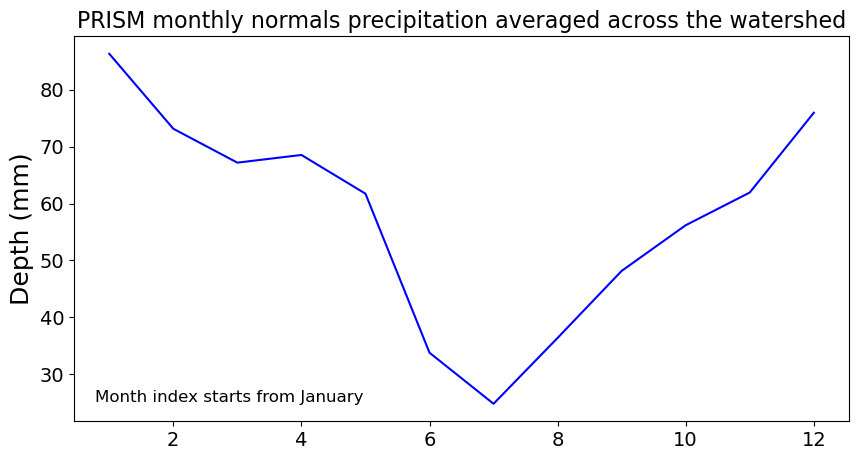

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
import matplotlib.pyplot as plt
ax.plot(df['Month'], df['Precipitation (mm)'], color='b')
ax.set_ylabel('Depth (mm)', size=18)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.set_title('PRISM monthly normals precipitation averaged across the watershed', size=16)
ax.annotate('Month index starts from January',xy=(0.2, 0.05), xycoords='axes fraction', fontsize=12, ha='center')
plt.show()

As we'd expect for a watershed in the arid Southwest, precipitation is lowest in the summer (with a minimum in July). We now have a time series for 30-year average precipitation for each watershed. In the next sections, we download another precipitation dataset to compare how precipitation patterns have changed in the last five years.

<div class="alert alert-block alert-info">
<b> NOTE: </b> Results for other watersheds will be plotted in the next section. </b>
</div>

In the following section, we download a second precipitation dataset. This is the Analysis of Record for Calibration (AORC) dataset, which is a forcing dataset used in the NWM developed by NOAA. You can read the documentation for the dataset from the Office of Water Prediction [here](https://hydrology.nws.noaa.gov/aorc-historic/Documents/AORC-Version1.1-SourcesMethodsandVerifications.pdf).

Essentiallly, this is the precipitation dataset that the NWM uses to model streamflow and other hydrological states and fluxes across the continental U.S. We want to calculate the monthly 5-year averages for each watershed from 2015-2019 and compare it to the 30-year normals we calculated above.

<div class="alert alert-block alert-info">
<b> NOTE: </b> To make this comparison more robust, we could calculate 5-year averages from daily PRISM dataset. However, the data processing requirements are much more significant and not possible to accomplish in the 5-day Summer School. Future work could re-run the analysis using PRISM daily values instead of AORC. Another option would be to calculate 30-year averages for AORC and compare the 30-year averages to the PRISM 30-year normals, to assess the input data quality for the NWM compared to the field standard. </b>
</div>

## 2.1. Import the AORC forcing dataset and aggregate to monthly and daily values

We have already obtained the AORC dataset when importing data from our [Hydroshare repository](https://www.hydroshare.org/resource/8e2fa6f38ce142e09fa1eb999cd5f248/). Our team leader has previously obtained and processed the hourly precipitation data for each watershed using the codes available in this [GitHub repository](https://github.com/igarousi/gsl-hydrology/tree/master/aorc-precipitation). It's worth noting that these codes are currently in the development stage, and the computational efficiency is not yet optimal. The reason for providing pre-processed data is to save time, avoiding the need for time-consuming data access and processing during the summer school. These are stored in a zipped folder. To proceed, we will utilize Bash to unzip the folders, making the AORC data accessible for each watershed. The data is hourly and in units of millimeters per second **(mm/s)**. 

Our objective is to calculate **5-year monthly averages** for each watershed. To achieve this, we need to perform a spatial aggregation across all the HUC8s within each basin. Additionally, we will convert the precipitation units from mm/s (a rate) to mm (a depth). We'll also need **daily averages** for each watershed for a later analysis; since the code is the same, we'll do both of these aggregations at once and save different CSV files for the different temporal aggregations. This helps us avoid having unecessary repetition of `for` loops, effectively reducing computational overhead.

In [33]:
%%bash
# You only need to run this code block once - don't rerun if you're rerunning other cells in the notebook,
# otherwise you'll unzip all the watershed data files multiple times

folder="./8e2fa6f38ce142e09fa1eb999cd5f248/data/contents/AORC"

for file in "$folder"/*.zip; do
    unzip -q "$file" -d "$folder"
done

In [34]:
%%bash

# now we'll use bash make an output folder for our aggregated AORC data (if it doesn't already exist)
folder="./AORC_outputs"

# check if the folder already exists or not
if [ ! -d "$folder" ]; then
    mkdir -p "$folder"
    echo "Directory created: $folder"
else
    echo "Directory already exists: $folder"
fi

Directory created: ./AORC_outputs


The next section includes a very long `for` loop to convert the hourly data for all constituent HUC8s to daily and monthly data for each watershed, so we've included more comment structures to help you see what's going on.

In [35]:
# create a list of watersheds to loop through
watershed_lst = ['WeberRiverBasin', 'BearRiverBasin', 'Jordan-ProvoRiverBasin']

############################
# Loop over each watershed #
############################
for watershed in watershed_lst:

    # set a string that corresponds to the name of the directory for each watershed in the AORC folder
    if watershed == 'WeberRiverBasin':
        tmp_str = 'weber'
    elif watershed == 'BearRiverBasin':
        tmp_str = 'bear'
    else:
        tmp_str = 'provo'

    #######################################################
    # Find out the distinct HUC8 codes for this watershed #
    #######################################################
    # set the filepath for the watershed-specific directory
    directory = f'./8e2fa6f38ce142e09fa1eb999cd5f248/data/contents/AORC/{tmp_str}'
    # set a regular expression pattern we can use to pull files for each HUC8
    pattern = r'(?<=_cat-)\d{8}(?=.csv)'
    # determine the HUC8 codes for the current watershed
    huc_lst = set()
    for filename in os.listdir(directory):
        match = re.search(pattern, filename)
        if match:
            huc_lst.add(match.group(0))
    huc_lst = [i for i in huc_lst]

    ########################################################
    # Loop over each .csv file and did the following:      #
    # 1. Convert to unit from mm/s to mm                   #
    # 2. Calculate daily and monthly sum in each sub-basin #
    # 3. Average the values of the sub-basins              #
    # 4. Store the results in one dictionary               #
    ########################################################
    daily_precip = {}
    monthly_precip ={}
    final_monthly_precip = pd.DataFrame()

    # for each HUC8
    for huc in huc_lst:

        # get a list of file paths that match the HUC8 code
        file_paths = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith(huc+'.csv')]

        # read the CSV files into a list of DataFrames
        dataframes = [pd.read_csv(file_path) for file_path in file_paths]

        # convert mm/s to mm
        for df in dataframes:
            df['P_mm'] = df['RAINRATE'] * 3600

        # concat the files
        combined_dataframe = pd.concat(dataframes, axis=0)

        # convert the 'time' column to a datetime object
        combined_dataframe['time'] = pd.to_datetime(combined_dataframe['time'])

        # remove duplicate time entries
        combined_dataframe.drop_duplicates(subset=['time'], keep='first', inplace=True)

        # set the 'time' column as the index
        combined_dataframe.set_index('time', inplace=True)

        # resample to calculate daily, monthly sums
        daily_sum_df = combined_dataframe['P_mm'].resample('D').sum()
        monthly_sum_df = combined_dataframe['P_mm'].resample('M').sum()

        # create a new DataFrame
        daily_precip_df = pd.DataFrame({
            'Date': daily_sum_df.index.strftime('%Y-%m-%d'),
            f'Daily_{huc}': daily_sum_df.values
        })

        monthly_precip_df = pd.DataFrame({
            'Month': monthly_sum_df.index.strftime('%Y-%m'),
            f'Monthly_Precip_{huc}': monthly_sum_df.values
        })

        # store the DataFrame in the dictionary
        daily_precip[huc] = daily_precip_df
        monthly_precip[huc] = monthly_precip_df

    #################################################################
    # 1. Concate the results in the dictionary into one dataframe   #
    # 2. Calculate water year                                       #
    # 3. Save the final output as a csv                             #
    #################################################################

    # convert the dictionary to a list of DataFrames
    daily_precip = list(daily_precip.values())
    monthly_precip = list(monthly_precip.values())

    # concatenate
    final_daily_precip = pd.concat(daily_precip, axis=1)
    final_daily_precip = final_daily_precip.loc[:, ~final_daily_precip.columns.duplicated()]

    final_monthly_precip = pd.concat(monthly_precip, axis=1)
    final_monthly_precip = final_monthly_precip.loc[:, ~final_monthly_precip.columns.duplicated()]

    # average across subbasins within the watershed (not averaging across time)
    final_daily_precip['avg'] = final_daily_precip.iloc[:, [1, -1]].mean(axis=1)
    final_monthly_precip['avg'] = final_monthly_precip.iloc[:, [1, -1]].mean(axis=1)

    # calculate Water Year
    final_daily_precip['Water_Year'] = pd.to_datetime(final_daily_precip['Date']).map(lambda x: x.year+1 if x.month>9 else x.year)
    final_monthly_precip['Water_Year'] = pd.to_datetime(final_monthly_precip['Month']).map(lambda x: x.year+1 if x.month>9 else x.year)

    # save the merged DataFrame as a CSV file
    output_directory = './AORC_outputs'
    filename_daily = f'{tmp_str}_daily_precip.csv'
    filename_monthly = f'{tmp_str}_monthly_precip.csv'

    final_daily_precip.to_csv(os.path.join(output_directory, filename_daily), index=False)
    final_monthly_precip.to_csv(os.path.join(output_directory, filename_monthly), index=False)

Now that we have the monthly values for each watershed for each year within the <font color=red> ./AORC_outputs </font> folder, we'll calculate the **5-year average monthly** precipitation. The output of the following code block will be three DataFrames, called `AORC_provo_monthly_precip`, `AORC_weber_monthly_precip`, and `AORC_bear_monthly_precip`. Even though we create them during a `for` loop, we can access them later because we store them as *global* variables instead of *local* variables (only relevant within the `for` loop).

In [36]:
# get a list of all monthly precipitation CSV files in the current directory
directory = './AORC_outputs'
csv_files = [file for file in os.listdir(directory) if file.endswith('monthly_precip.csv')]

# loop through each CSV file (i.e., each watershed)
for csv_file in csv_files:

    # read the CSV file into a DataFrame
    df = pd.read_csv(f'{directory}/'+csv_file)

    # extract the "Month" and "avg" columns
    month_col = df['Month']
    avg_col = df['avg']

    # initialize a dictionary to store monthly averages within each CSV file
    monthly_averages = {str(month).zfill(2): [] for month in range(1, 13)}

    # update the dictionary with the average values for each month within this CSV file
    for month, avg in zip(month_col, avg_col):
        month_key = month.split('-')[1]  # get the month part (e.g., '01' from '2015-01')
        monthly_averages[month_key].append(avg)

    # calculate the average of each month over the 5-year range for this CSV file
    result_data = {'Month': [], 'Monthly_Avg': []}
    for month, avg_list in monthly_averages.items():
        avg = sum(avg_list) / len(avg_list)
        result_data['Month'].append(month)
        result_data['Monthly_Avg'].append(avg)

    # create the final DataFrame for this CSV file
    result_df = pd.DataFrame(result_data)

    # get the base name of the CSV file (without file extension)
    csv_base_name = os.path.splitext(csv_file)[0]

    # create a variable name and store the result DataFrame in it as a global variable
    variable_name = f"AORC_{csv_base_name}"
    globals()[variable_name] = result_df

## 2.2 Plot PRISM vs. AORC


Next, we read back in the files with the PRISM 30-year normals we calculated for each watershed above. The resulting PRISM variables are called `PRISM_Monthly_Normal_Precipitation_W` for the Weber River, `PRISM_Monthly_Normal_Precipitation_J` for the Jordan-Provo River, and `PRISM_Monthly_Normal_Precipitation_B` for the Bear River.

Then, we merge the PRISM and AORC precipitation data into one DataFrame to facilitate plotting.

In [39]:
# specify the directory containing the PRISM CSV files
directory = "./PRISM_monthly_normals/outputs"

# get a list of all CSV files in the directory
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

# loop through each CSV file
for csv_file in csv_files:

    # read the CSV file into a DataFrame
    df = pd.read_csv(os.path.join(directory, csv_file))

    # find the name of the CSV file to determine which watershed it is
    csv_base_name = csv_file[0:36]

    # convert month column to a common format (e.g., '01', '02')
    if 'Month' in df.columns:
        df['Month'] = df['Month'].apply(lambda x: str(x).zfill(2))

    # create a variable name and store the DataFrame in it
    variable_name = f"{csv_base_name}"
    globals()[variable_name] = df

In [40]:
# merge the DataFrames based on the "Month" column
merged_provo = pd.merge(AORC_provo_monthly_precip, PRISM_Monthly_Normal_Precipitation_J, on="Month")
merged_bear = pd.merge(AORC_bear_monthly_precip, PRISM_Monthly_Normal_Precipitation_B, on="Month")
merged_weber = pd.merge(AORC_weber_monthly_precip, PRISM_Monthly_Normal_Precipitation_W, on="Month")

# merging creates an additional column, so we drop it
merged_provo = merged_provo.drop(columns=['Unnamed: 0'])
merged_bear = merged_bear.drop(columns=['Unnamed: 0'])
merged_weber = merged_weber.drop(columns=['Unnamed: 0'])

Now that we have all the data for PRISM and AORC in one DataFrame for each watershed, we can plot the 30-year normal from PRISM versus the 5-year average from AORC. Remember that we have all the basin names stored in the variable `watershed_lst`, so we loop through the watersheds in the same order as that variable and title the suplots according to the watershed name.

In [41]:
watershed_lst

['WeberRiverBasin', 'BearRiverBasin', 'Jordan-ProvoRiverBasin']

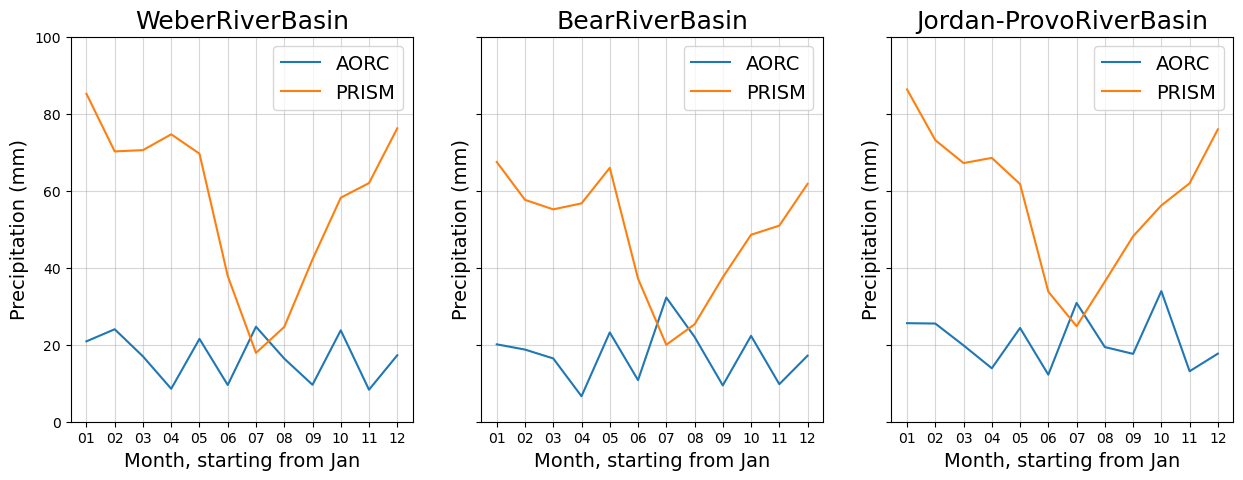

In [42]:
# create a figure and three subplots in one row
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, gridspec_kw={'hspace': 0.5})

# set a counter for subsetting the subplots as we loop through the watersheds
count = 0

# loop through the DataFrames for each watershed and plot them on a separate subplot
for merged in [merged_weber, merged_bear, merged_provo]:
    axs[count].plot(merged['Month'], merged['Monthly_Avg'], label='AORC')
    axs[count].plot(merged['Month'], merged['Precipitation (mm)'], label='PRISM')
    axs[count].set_title(f'{watershed_lst[count]}', fontsize=18)
    axs[count].set_xlabel('Month, starting from Jan', fontsize=14)
    axs[count].set_ylabel('Precipitation (mm)', fontsize=14)
    axs[count].set_ylim(0,100)
    axs[count].legend(fontsize=14)
    axs[count].grid(alpha=0.5)

    # increment the counter for subsetting
    count += 1

# Show the plots
plt.show()

As we can see above, the 5-year AORC data does not closely match the 30-year long-term average from PRISM.

<div class="alert alert-block alert-success">
<b> Delving Deeper: The two timeseries look so different, we double-checked our workflow above to ensure we were not aggregating the data erroneously, but we were not able to find any errors (we welcome feedback if you find one!). We also checked the PRISM online web interface to evaluate anomolies in the months/years for which we have AORC data, and the monthly values in PRISM appear to be similar to the AORC values. As we discussed above, it would be a better comparison to use PRISM hourly data and then calculate the 5-year average to compare to the PRISM 30-year average, but downloading PRISM hourly data would take several hours per watershed. We leave this for future work, but if we do complete that analysis, we can compare the PRISM 5-year data to the AORC 5-year data to more directly assess AORC data quality as well. </b> 

</div>

Regardless, we see much more precipitation variability across the year in the short term than in the long term.

# <font color='blue'> **Analysis II.** </font> Compare National Water Model simulated streamflow to observations from USGS

<div style="background-color: whitesmoke; padding: 10px; box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.2); color: #333;">
This analysis compares the modeled streamflow to observed streamflow from the USGS gages. The point of this exercise is to determine how accurate the NWM is.  

</div>



The second analysis includes two main steps:  <b/>

**Step 3**. Prepare the simulated streamflow data from NWM for each watershed
> 3.1 Import NWM streamflow data \
> 3.2 Retrieve the NWM streamflow data for the outlet locations


**Step 4**. Prepare the observed streamflow data from USGS for each watershed
> 4.1. Import USGS stream gage data \
> 4.2. Plot modeled (NWM) vs. observed (USGS) runoff time series 


## 3.1. Import NWM streamflow data


The NWM generates estimates of streamflow, along with lots of other hydrological variables, based on meteorological and geophysiological input datasets and models like groundwater flow, lake and reservoir models, land surface processes, etc. You can find an overview from NOAA's Office of Water Prediction here: https://water.noaa.gov/about/nwm. 

The output we're interested is called **"channel routing"**, since rivers and streams are called channels in the model. This is the same as modeled streamflow or modeled discharge. The modeled discharge is available at the same locations as USGS reference stream gage locations, which collect observational data about streamflow across the continental U.S. NWM also predicts discharge at locations without a reference USGS gage, making it useful for water management in areas that don't have local observational data. Abdelkader and Bravo Mendez (2023) provided a table that shows relationship between NWM feature IDs with the associated USGS gage IDs. You can find metadata about the various model outputs here: https://water.noaa.gov/about/output_file_contents.

The NWM data are hosted on an Amazon Web Services (AWS) storage infrastructure called the Simple Storage Service (S3) in a file format called **Zarr**. Zarr is a compressed file format that stores N-dimensional ways in chunks, where each chunk is compressed as a programmatic object. These objects are optimized for storage and retrieval, making it a more efficient way to store large multi-dimensional arrays like the NWM outputs. If you want to learn more about Zarr, check out the explanation and tutorial at https://zarr.readthedocs.io/en/stable/getting_started.html.

We're going to access the data from AWS S3 and use the Python package **`xarray`** which we imported earlier in one of our first code chunks, to import and reformat these Zarr files. This is the link to the data on AWS in case you want to look at documentation: https://registry.opendata.aws/nwm-archive/.

Reference:
- https://github.com/NCAR/rechunk_retro_nwm_v21/blob/main/notebooks/usage_example_streamflow_timeseries.ipynb
- Abdelkader, M., J. H. Bravo Mendez (2023). NWM version 2.1 model output data retrieval, HydroShare, https://doi.org/10.4211/hs.c4c9f0950c7a42d298ca25e4f6ba5542

First, we'll have our system print all of the files that are available for us to download from AWS S3, without actually downloading anything.

In [66]:
# use fsspec to get a list of available files within the amazon AWS 3
fs = fsspec.filesystem('s3', anon=True)
fs.glob('noaa-nwm-retrospective-2-1-zarr-pds/')

['noaa-nwm-retrospective-2-1-zarr-pds']

We can see that there are lots of different NWM files. As we discussed above, we only want channel routing. This is stored in the file ending in ".../**chrtout.zarr**". Let's download it.

In [44]:
%%time

# use xarray to access the chrtout zarr file
file = fs.glob('noaa-nwm-retrospective-2-1-zarr-pds/chrtout.zarr')
ds = xr.open_dataset(fs.get_mapper(file[0]), engine='zarr', backend_kwargs={'consolidated': True})

CPU times: user 2.02 s, sys: 91.4 ms, total: 2.11 s
Wall time: 6.24 s


If you're curious about that `%%time` command, it's a "magic command" in Jupyter notebooks that prints the time taken to execute a cell block. It reports the time taken on the actual computations (CPU times), time taken for system overhead (sys), and total execution time (total), as well as the "wall clock" time, i.e., how long you and I would perceive it running for.

Now we can start working with the data. The next step is important - when you import a Zarr file/any type of data that is chunked for storage, you need to tell the system how to "**re-chunk**" the data. The code block below tells Python to create chunks of 1,000 gages each based on the timestamp, and print how long it takes.

In [45]:
%%time

# create chunks to optimize the memory usage
dim_chunk_sizes = {'feature_id': 1000, 'time': len(ds.time)} # treat time as one dimension, but chunk by 1000 gauges (trial and error but there is documentation to determine optimal)
ds = ds.chunk(chunks=dim_chunk_sizes)

CPU times: user 11.8 ms, sys: 622 µs, total: 12.4 ms
Wall time: 12 ms


We'll also select only the timeframe we want for this analysis, i.e. from the start of water year 2016 (October 1, 2015) to the end of water year 2019 (September 30, 2019, but we will use October 1, 2019 to make sure the last day of water year 2019 is included in our subsetted data).

In [46]:
%%time

# slice the dataset for a period of interest
start_time = f'2015-10-01 00:00'
end_time = f'2019-10-01 00:00'

# isolate the desired time period of our data
ds_subset = ds.sortby('time').sel(time=slice(start_time, end_time))

print(f'The dataset contains {len(ds_subset.time)} timesteps')

The dataset contains 35065 timesteps
CPU times: user 23.6 ms, sys: 4.77 ms, total: 28.4 ms
Wall time: 27.4 ms


In [47]:
len(ds_subset.time)

35065

## 3.2. Retrieve the NWM streamflow data for the outlet locations


From Step 3.1., we can see 35065 timesteps are selected. That's a lot of timesteps! But we haven't fully downloaded all the data; `xarray` uses something called "**lazy reading**" so it can download the metadata but won't save the actual data to memory until we tell it to. Before we do that, we need to subset by our region of interest. To do that, we need to know the USGS reference stream gage numbers associated with our 3 rivers, and map those to the river names. We use the list of names for saving the files later on. Once we have a list of the USGS gages, we can find the corresponding NWM IDs for those gages.

In [48]:
# IDs for the outlets of the Bear River, Weber River, and Jordan-Provo River
USGS_gages = ['10126000', '10141000', '10168000']

# this list is used for file saving purposes only
USGS_gage_names = ['bear', 'weber', 'jordan']

In the next step, we download a Microsoft Excel file from the work of Abdelkader, M., J. H. Bravo Mendez (2023), where they have already mapped the USGS gage IDs to the NWM IDs and made it publicly available on [HydroShare](https://doi.org/10.4211/hs.c4c9f0950c7a42d298ca25e4f6ba5542). You'll need your Hydroshare login and password again!

In [49]:
hs = HydroShare()
hs.sign_in()

Username:  kat-ffowler
Password for kat-ffowler:  ········


In [50]:
# get the resource you want to download using its identifier
res = hs.resource('c4c9f0950c7a42d298ca25e4f6ba5542')
res.download()

'c4c9f0950c7a42d298ca25e4f6ba5542.zip'

The zip file is stored in your working directory. We'll use bash to unzip it (with the `-q` flag to avoid printing all the files it is inflating).

In [51]:
!unzip -q c4c9f0950c7a42d298ca25e4f6ba5542.zip

Now we'll extract the USGS gage IDs and **corresponding NWM IDs** from the file NWM_USGS_Natural_Flow.xlsx. We use the Python command `read_excel` instead of `read_csv` like we have used before because Excel has some proprietary formatting and needs to be read in differently.

In [52]:
# specify the file
file = 'c4c9f0950c7a42d298ca25e4f6ba5542/data/contents/NWM_USGS_Natural_Flow.xlsx'
usgs_stations = pd.read_excel(os.path.join(os.getcwd(), file))
# do the mapping from USGS to NWM
usgs_stations['USGS_ID'] = usgs_stations['USGS_ID'].apply(lambda x: '{:0>8}'.format(x))
# read the assiciated NWM id
NWM_feature_ids = list(usgs_stations[usgs_stations['USGS_ID'].isin(USGS_gages)]['NWM_ID'])
NWM_feature_ids

[4605050, 10273232, 10389562]

Lastly, let's **clip our data** so we only have NWM discharge for our rivers of interest. We'll create an output folder and store the files there.

The `try` loop below tells the system how to distribute resources to actually read in the NWM data, instead of the "lazy reading" we mentioned above. We set the number of "workers" i.e., computational resources, we need and how much memory each of them should have. This is an important optimization step for reading in complicated multi-dimensional data like the NWM arrays; you can customize the resources you are requesting to suit your use case and available resources.

We loop through each gage in the last `for` loop and save files based on the river name.

In [53]:
# create an output directory to save results
!mkdir nwm_outputs

To enhance computation speed and leverage the parallel processing resources provided by the I-GUIDE platform, we utilize the **`Client`** function from the **Dask Distributed** Python package to establish a local cluster. In this configuration, setting `n_workers=-1` signifies the utilization of all available processing units, each allocated with a memory capacity of 2 GB. You can explore further details about Dask at https://distributed.dask.org/en/latest/.

In [54]:
# use a try accept loop so we only instantiate the client
# if it doesn't already exist.
try:
    print("")
except:
    # the client should be customized to your workstation resources.
    client = Client(n_workers=-1, memory_limit='2GB') # per worker

In [55]:
%%time

for i in range(0,3):

    print('Retrieving data for gage: ', USGS_gages[i])

    ds_subset_one = ds_subset.sel(feature_id=NWM_feature_ids[i])
    ds_subset_one = ds_subset_one.compute()

    df = ds_subset_one['streamflow'].to_pandas().to_frame()

    df.rename(columns={0: f"Discharge {ds.streamflow.units}"}, inplace=True)
    df_resampled = df.resample('D').mean()
    df_resampled.to_csv(os.path.join('./nwm_outputs/', f'nwm_q_{USGS_gage_names[i]}.csv'))

Retrieving data for gage:  10126000
Retrieving data for gage:  10141000
Retrieving data for gage:  10168000
CPU times: user 12.9 s, sys: 5.46 s, total: 18.4 s
Wall time: 22.6 s


You should have three CSVs in <font color='red'> ./nwm_outputs </font> folders, called `nwm_q_bear.csv`, `nwm_q_jordan.csv`, and `nwm_q_weber.csv`. We use "q" in the name because in hydrology, discharge/runoff is usually denoted as "Q". As a note, since we're using daily values, the time zone is not as important. However, if you wanted to look at hourly data for different gages, you might need to standardize your time zone. USGS local time zones differ from the "universal" UTM time zone used by the NWM.

## 4.1. Import USGS stream gage data


The USGS reports streamflow across several timescales (e.g., hourly, daily). We retrieve the **daily average** values for water years 2016-2019 using the `nwis` function from the **`dataretrieval`** package following Horsburgh et al. (2022). To do this you need the parameter code for your feature of interest. Here, the code is "0060" for discharge.

The data are given in cubic feet per second (cfs), but the NWM data we want to compare to reports data in cubic *meters* per second (cms). We use a conversion parameter **`cfs_2_cms`** to convert to the same unit (cms) for comparison.

Reference:
- Horsburgh, J. S., A. S. Jones, S. S. Black, T. O. Hodson (2022). USGS dataretrieval Python Package Usage Examples, HydroShare, http://www.hydroshare.org/resource/c97c32ecf59b4dff90ef013030c54264

In [56]:
# make a folder to store the retrieved data
!mkdir usgs_outputs

In [57]:
# Bear River, Weber River, and Jordan-Provo River
USGS_gages = ['10126000', '10141000', '10168000']

# unit conversion parameter
cfs_2_cms = 0.028316846592

In [58]:
# Set the parameters needed to retrieve data
parameterCode = "00060"  # Discharge
startDate = "2015-10-01"
endDate = "2019-10-01"

# Retrieve the data
dailyStreamflow = nwis.get_dv(sites=USGS_gages, parameterCd=parameterCode, start=startDate, end=endDate) # multiple sites
dailyStreamflow[0]

00060_Mean 00060_Mean_cd
site_no  datetime                                           
10126000 2015-10-01 00:00:00+00:00       226.0             A
         2015-10-02 00:00:00+00:00       269.0             A
         2015-10-03 00:00:00+00:00       338.0             A
         2015-10-04 00:00:00+00:00       308.0             A
         2015-10-05 00:00:00+00:00       458.0             A
...                                        ...           ...
10168000 2019-09-27 00:00:00+00:00        17.6             A
         2019-09-28 00:00:00+00:00        12.9             A
         2019-09-29 00:00:00+00:00        39.4             A
         2019-09-30 00:00:00+00:00        22.1             A
         2019-10-01 00:00:00+00:00        13.9             A

[4386 rows x 2 columns]

The DataFrame above shows the daily average value in cfs for all three gages. We save them to different dataframes and convert to cms below.

In [59]:
dailyStreamflow_bear = dailyStreamflow[0].loc[USGS_gages[0]]
dailyStreamflow_weber = dailyStreamflow[0].loc[USGS_gages[1]]
dailyStreamflow_jordan = dailyStreamflow[0].loc[USGS_gages[2]]

In [60]:
dailyStreamflow_bear['00060_Mean cms']=dailyStreamflow_bear['00060_Mean']*cfs_2_cms
dailyStreamflow_weber['00060_Mean cms']=dailyStreamflow_weber['00060_Mean']*cfs_2_cms
dailyStreamflow_jordan['00060_Mean cms']=dailyStreamflow_jordan['00060_Mean']*cfs_2_cms

Let's plot the observed streamflow across all 3 rivers from water year 2016 to water year 2019, then export our data to CSV to capture this data retrieval step.

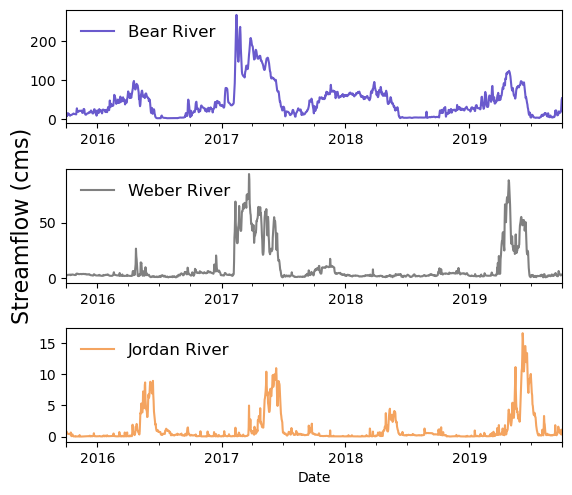

In [61]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.4)

dailyStreamflow_bear['00060_Mean cms'].plot(ax=axes[0], color='slateblue')
dailyStreamflow_weber['00060_Mean cms'].plot(ax=axes[1], color='gray')
dailyStreamflow_jordan['00060_Mean cms'].plot(ax=axes[2], color='sandybrown')

axes[0].legend(['Bear River'], fontsize=12, frameon=False, loc='upper left')
axes[1].legend(['Weber River'], fontsize=12, frameon=False, loc='upper left')
axes[2].legend(['Jordan River'], fontsize=12, frameon=False, loc='upper left')

for i in range(0,3):
    if i == 2:
        axes[i].set_xlabel('Date')
    else:
        axes[i].set_xlabel('')
        
axes[1].set_ylabel('Streamflow (cms)', fontsize=16)

plt.show()

<div class="alert alert-block alert-success">
<b> Delving Deeper: Take note of the significant variation in streamflow value ranges among the three watersheds. The Bear River dataset exhibits the widest range, reaching a maximum value exceeding 200 cms, whereas the Jordan River dataset presents the narrowest range, with its maximum value hovering around 15 cms.  </b> 

</div>

In [62]:
# save dataframes
dailyStreamflow_bear.to_csv('./usgs_outputs/obs_q_bear.csv')
dailyStreamflow_weber.to_csv('./usgs_outputs/obs_q_weber.csv')
dailyStreamflow_jordan.to_csv('./usgs_outputs/obs_q_jordan.csv')

## 4.2. Plot NWM vs. USGS stream gage time series

In this section we'll read our USGS and NWM data back in from their CSV files and compare them. Our USGS variables are actually still saved in memory so we could avoid importing them, but for consistent notation and simplicity in the `for` loop, we import both CSVs for each watershed at the same time. Input-output (I/O) tends to be the most computationally itnensive task, so in future work we could alter the code below to only import the NWM CSVs, or change the NWM import code to save those as global variables too so we don't have to read either in.

The comparison plots inlcude:
> - Plot #1: A sub-panel timeseries plot comparing the observed and modeled streamflow rates in the Bear, Jordon-Provo, and Weber River basins. One sub-panel is created for each river basin.
> - Plot #2: Scatter plot showing comparison between USGS observation and NWM modeled values (coming soon)


In [68]:
# define paths to data source
nwm_folder = "./nwm_outputs/"
usgs_folder = "./usgs_outputs/"

# use glob to get set of files
glob_nwm_gridpoints = sorted(glob.glob(f'{nwm_folder}/*.csv'))
glob_usgs_discharge = sorted(glob.glob(f'{usgs_folder}/*.csv'))

# print set of files as a sanity check
display(glob_nwm_gridpoints)
display(glob_usgs_discharge)

['./nwm_outputs/nwm_q_bear.csv',
 './nwm_outputs/nwm_q_jordan.csv',
 './nwm_outputs/nwm_q_weber.csv']

['./usgs_outputs/obs_q_bear.csv',
 './usgs_outputs/obs_q_jordan.csv',
 './usgs_outputs/obs_q_weber.csv']

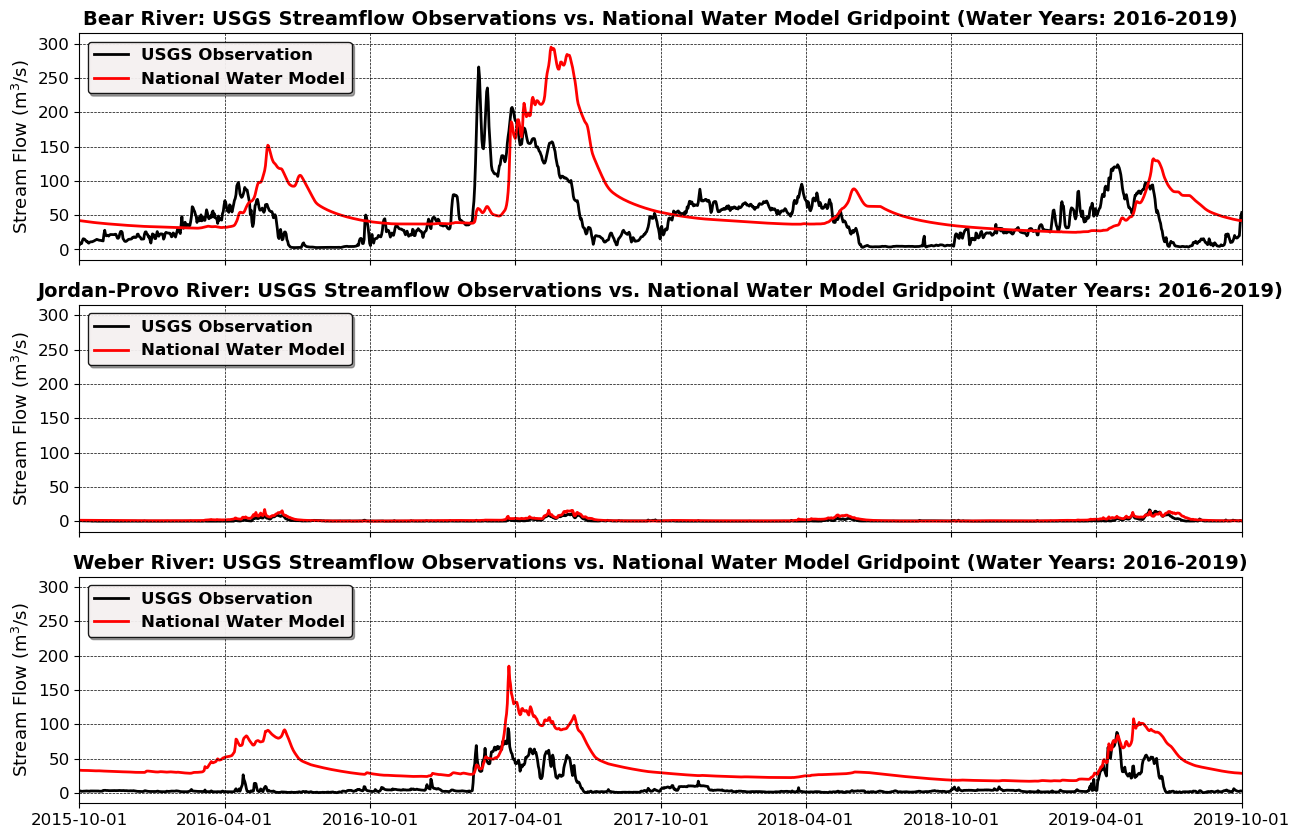

In [69]:
# define figure and axis for plotting
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15,10))

# define font dictionaries for plotting
fontdict_legend_labels   = {'size': 12, 'weight': 'bold'}
fontdict_tick_labels     = {'fontsize': 12, 'fontweight': 'normal'}
fontdict_axis_labels     = {'fontsize': 14, 'fontweight': 'bold'}
fontdict_title_labels    = {'fontsize': 14, 'fontweight': 'bold'}
fontdict_text_color_bar  = {'fontsize': 15, 'fontweight': 'normal'}
fontdict_text_annotation = {'fontsize': 12, 'fontweight': 'normal'}

# define xtick and xticklabels for subplots
# these will be datetime objects that represent each year we are plotting
ax_xticks      = pd.to_datetime(['2015-10-01', '2016-04-01', '2016-10-01', '2017-04-01', '2017-10-01', '2018-04-01', '2018-10-01', '2019-04-01', '2019-10-01'])
ax_xticklabels = ['2015-10-01', '2016-04-01', '2016-10-01', '2017-04-01', '2017-10-01', '2018-04-01', '2018-10-01', '2019-04-01', '2019-10-01']

# for each subplot (watershed), do the following
for ax_index, ax in enumerate(axs):

    # read in USGS observation file, and NWM gridpoint file, into pandas DataFrame
    df_usgs_obs      = pd.read_csv(glob_usgs_discharge[ax_index])
    df_nwm_gridpoint = pd.read_csv(glob_nwm_gridpoints[ax_index])

    # y-axis customizations
    ax_ymin = 0
    ax_ymax = 300
    ax_ystep = 50
    ax_yticks = np.arange(ax_ymin, ax_ymax+ax_ystep, ax_ystep)
    ax_yticklabels = ax_yticks
    ax.set_yticks(ax_yticks)
    ax.set_yticklabels(ax_yticklabels, fontdict=fontdict_tick_labels)
    ax.set_ylabel('Stream Flow (m$^3$/s)', fontsize=13)

    # plot a horizontal line that spands the entire y-axis for each of the x_ticks we have
    for x_tick in ax_xticks:
        ax.axvline(x=x_tick, ymin=0, ymax=1, color='black', linestyle='--', linewidth=0.5, zorder=2)

    # plot a horizontal lines that spans the entire x-axis for each of the y_ticks we have
    for y_tick in ax_yticks:
        ax.axhline(y=y_tick, xmin=0, xmax=1, color='black', linestyle='--', linewidth=0.5, zorder=2)

    # plot USGS observation and corresponding NWM gridpoint for each river
    ax.plot(pd.to_datetime(df_usgs_obs['datetime']), df_usgs_obs['00060_Mean cms'], color='black', label='USGS Observation', linestyle='-', linewidth=2, zorder=1)
    ax.plot(pd.to_datetime(df_nwm_gridpoint['time']), df_nwm_gridpoint['Discharge m3 s-1'], color='Red', label='National Water Model', linestyle='-', linewidth=2, zorder=1)

    # add legend
    ax.legend(loc='upper left', ncol=1, fancybox=True, shadow=True, framealpha=0.9, facecolor='snow', edgecolor='black', prop=fontdict_legend_labels)

    # add titles to each subplot corresponding to the river it is representing
    if ax_index == 0:
        ax.set_title('Bear River: USGS Streamflow Observations vs. National Water Model Gridpoint (Water Years: 2016-2019)', **fontdict_title_labels)
    if ax_index == 1:
        ax.set_title('Jordan-Provo River: USGS Streamflow Observations vs. National Water Model Gridpoint (Water Years: 2016-2019)', **fontdict_title_labels)
    if ax_index == len(axs)-1:
        ax.set_title('Weber River: USGS Streamflow Observations vs. National Water Model Gridpoint (Water Years: 2016-2019)', **fontdict_title_labels)

        # x-axis customizations for last (bottom) axis
        ax.set_xlim([ax_xticks[0],ax_xticks[-1]])
        ax.set_xticks(ax_xticks)
        ax.set_xticklabels(ax_xticklabels, fontdict=fontdict_tick_labels)

At first glance, the patterns between observed and modeled streamflow seem similar but slightly offset temporally and NWM looks like the predictions are higher. Let's run one more analysis before we interpret these data

The code block below computes the root mean sqaure error (RMSE) for predicted vs. observed streamflow using the **`mean_sqaured_error`** function from the `sklearn` Python package. This is an error statistic that tells us how different the NWM is compared to the USGS values. RMSE is typically calculated for the entire dataset; we calculate RMSE this way, and calculate RMSE for points where the NWM is predicting higher streamflow and lower streamflow, respectively. The idea was to look for trends in how the model over- or under-estimates streamflow.

In [ ]:
# define figure and axis for plotting
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19,6), gridspec_kw=dict(hspace=0.25))

# define font dictionaries for plotting
fontdict_legend_labels   = {'size': 14, 'weight': 'bold'}
fontdict_tick_labels     = {'fontsize': 12, 'fontweight': 'normal'}
fontdict_axis_labels     = {'fontsize': 14, 'fontweight': 'bold'}
fontdict_title_labels    = {'fontsize': 12, 'fontweight': 'bold'}
fontdict_text_annotation = {'fontsize': 12, 'fontweight': 'normal'}

# for each subplot (watershed), do the following
for ax_index, ax in enumerate(axs):

    # read in USGS observation file, and NWM gridpoint file, into pandas DataFrame
    df_usgs_obs      = pd.read_csv(glob_usgs_discharge[ax_index])
    df_nwm_gridpoint = pd.read_csv(glob_nwm_gridpoints[ax_index])

    # compute mean absolute error, root mean square error, and R^2 for each plot
    # round values to nearest 2 decimal points for display purposes in legend
    rmse_total = np.round(mean_squared_error(df_usgs_obs['00060_Mean cms'], df_nwm_gridpoint['Discharge m3 s-1'], squared=False), 2)
    rmse_above = np.round(mean_squared_error(df_usgs_obs['00060_Mean cms'][np.where(df_nwm_gridpoint['Discharge m3 s-1'] > df_usgs_obs['00060_Mean cms'])[0]], df_nwm_gridpoint['Discharge m3 s-1'][np.where(df_nwm_gridpoint['Discharge m3 s-1'] > df_usgs_obs['00060_Mean cms'])[0]], squared=False), 2)
    rmse_below = np.round(mean_squared_error(df_usgs_obs['00060_Mean cms'][np.where(df_nwm_gridpoint['Discharge m3 s-1'] < df_usgs_obs['00060_Mean cms'])[0]], df_nwm_gridpoint['Discharge m3 s-1'][np.where(df_nwm_gridpoint['Discharge m3 s-1'] < df_usgs_obs['00060_Mean cms'])[0]], squared=False), 2)

    # add legend with RMSE info
    legend_title = f'Total RMSE: {rmse_total}\nAbove RMSE: {rmse_above}\nBelow RMSE: {rmse_below}'
    ax.legend(title=legend_title, loc='upper right', ncol=1, fancybox=True, shadow=True, framealpha=1, facecolor='snow', edgecolor='black', prop=fontdict_legend_labels)

    # plot USGS observation and corresponding NWM gridpoint for each river
    ax.scatter(df_usgs_obs['00060_Mean cms'], df_nwm_gridpoint['Discharge m3 s-1'], s=10, c='blue', marker='o', zorder=1)

    # create variables for title string and axis bounds for each subplot based on its index
    if ax_index == 0:
        tmp_title = 'Bear River \n USGS Obs vs. NWM Gridpoint  \n WY: 2015-2019'
        ax_xmin, ax_xmax, ax_xstep, ax_ymin, ax_ymax, ax_ystep = [0,300,25,0,300,25]
    if ax_index == 1:
        tmp_title = 'Jordan-Provo River \n  USGS Obs vs. NWM Gridpoint  \n WY: 2015-2019'
        ax_xmin, ax_xmax, ax_xstep, ax_ymin, ax_ymax, ax_ystep = [0,20,2,0,20,2]
    if ax_index == 2:
        tmp_title = 'Weber River \n USGS Obs vs. NWM Gridpoint  \n WY: 2015-2019'
        ax_xmin, ax_xmax, ax_xstep, ax_ymin, ax_ymax, ax_ystep = [0,300,25,0,300,25]

    # set title
    ax.set_title(tmp_title, **fontdict_title_labels)

    # x-axis customizations
    ax_xticks = np.arange(ax_xmin, ax_xmax+ax_xstep, ax_xstep)
    ax_xticklabels = ax_xticks
    ax.set_xlim([ax_xmin, ax_xmax])
    ax.set_xticks(ax_xticks)
    ax.set_xticklabels(ax_xticklabels, fontdict=fontdict_tick_labels)
    ax.set_xlabel('Observed Stream Flow (m$^3$/s)', fontsize=14)

    # y-axis customizations
    ax_yticks = np.arange(ax_ymin, ax_ymax+ax_ystep, ax_ystep)
    ax_yticklabels = ax_yticks
    ax.set_ylim([ax_ymin, ax_ymax])
    ax.set_yticks(ax_yticks)
    ax.set_yticklabels(ax_yticklabels, fontdict=fontdict_tick_labels)
    ax.set_ylabel('Modeled Stream Flow (m$^3$/s)', fontsize=14)

    # plot the x and yticks against each other to have a 1:1 line
    ax.plot(ax_xticks, ax_yticks, color='black', linewidth=1)

<div class="alert alert-block alert-success">
<b> Discussion: 

In general, the **NWM predictions appear to be higher than the observed values**. We see this both in the time series of streamflow above, and in the scatterplots we just made. For the scatterplots, the black line represents a 1:1 correlation between the modeled and observed values (i.e., if they were a perfect match). Points above the line indicate that the NWM values are higher than observed values for the timestep, while points below the line indicate that the NWM values are lower than observed values for the timestep.

- This pattern is likely because the NWM is simulating natural streamflow, which does not consider human uses, while the USGS measures the actual water in the river, which is influenced by human consumptive withdrawals and inter-basin transfers. Water from the Bear, Weber, and Jordan-Provo watersheds is diverted for agriculture, cities, and other uses (Null & Wurtsbaugh, 2020). Advisory boards comprised of scientists, policymakers, and other stakeholders around the Great Salt Lake are interested in understanding the total water budget for the lake and the three watersheds that feed it (Eisenhauer & Nicholson, 2005). These groups argue that the human causes of lake levels are being masked by droughts and wet cycles, and that we therefore need a clear water budget to inform any actionable change (Wurtsbaugh et al., 2017). Using another water balance model that can incorporate human use and account for streamflow, or an effort to optimize the NWM for the Great Salt Lake (or at least Intermountain West on the whole) would likely improve predictions.

- There is also a mismatch between peak flowss, with variations spanning 1-2 months. One possible explanation for these disparities may be the limitations in the physical representation of snow processes within the NWM model, leading to inaccuracies in snowmelt values (Garousi-Nejad and Tarboton, 2022). These inaccuracies have a substantial impact on the streamflow in this region, given its heavy reliance on snowmelt. This discussion pertains to the applicability of the NWM for water supply prediction. While the NWM has undergone calibration for the entire continental U.S., it lacks specific calibration for local regions. Consequently, the model employs spatially averaged parameters that my not provide accurate predictions for smaller areas, such as the watersheds of interest. Furthermore, the model has most often been used for flood prediction, focusing on short-term forecasts spanning hours, days, or weeks.  Its suitability for long-term water supply prediction remains uncertain. Presently, there is a growing effort among researchers in various regions to use the NWM inputs and code while customizing them to align more closely with local observations. These regional adaptions can then potentially be reported to the Office of Water Prediction, enabling the incorporation of regionally-specific parameters and modifications. Additionally, some researchers are working on modifying the NWM code to include modules capable of accommodating different scenarios, such as variations in human water use.

**References**:
- Eisenhauer, B. W., & Nicholson, B. (2005). Using Stakeholders’ Views: A Social Science Methodology for the Inclusive Design of Environmental Communications. Applied Environmental Education & Communication, 4(1), 19–30. https://doi.org/10.1080/15330150590910701
- Garousi-Nejad, I., & Tarboton, D. G. (2022). A comparison of National Water Model retrospective analysis snow outputs at snow telemetry sites across the Western United States. Hydrological Processes, 36(1), e14469. https://doi.org/10.1002/hyp.14469
- Null, S. E., & Wurtsbaugh, W. A. (2020). Water Development, Consumptive Water Uses, and Great Salt Lake. In B. K. Baxter & J. K. Butler (Eds.), Great Salt Lake Biology: A Terminal Lake in a Time of Change (pp. 1–21). Springer International Publishing. https://doi.org/10.1007/978-3-030-40352-2_1
- Thorsen, M. L., Handy, R. G., Sleeth, D. K., Thiese, M. S., & Riches, N. O. (2017). A comparison study between previous and current shoreline concentrations of heavy metals at the Great Salt Lake using portable X-ray fluorescence analysis. Human and Ecological Risk Assessment: An International Journal, 23(8), 1941–1954. https://doi.org/10.1080/10807039.2017.1349541
- Wurtsbaugh, W. A., Miller, C., Null, S. E., DeRose, R. J., Wilcock, P., Hahnenberger, M., Howe, F., & Moore, J. (2017). Decline of the world’s saline lakes. Nature Geoscience, 10(11), Article 11. https://doi.org/10.1038/ngeo3052
    
</b>
</div>


# <font color='blue'> **Analysis III.** </font> Compare the cumulative precipitation and runoff for each water year

<div style="background-color: whitesmoke; padding: 10px; box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.2); color: #333;">
This analysis compares cumulative AORC precipitation to cumulative NWM runoff (i.e., discharge converted into depth). The point of this exercise is to make inferences about how the input precipitation data influences outputs. In hydrology, we expect precipitation to be higher than runoff, since water models cannot produce water. This is especially true since the National Water Model version we are using incorporates AORC as a forcing dataset. Let's see if it works out that way. 

</div>
 

We actually were able to download daily PRISM data by this point in the week, so we incorporated it into this analysis. Here, we compare the cumulative PRISM and AORC precipitation to cumulative USGS and NWM streamflow. This accomplishes several things. It visualized:
- how the precipitation datasets relate to one another, 
- how the streamflow datasets relate to one another, and 
- how the quality of the AORC input dataset for the NWM might be affecting modeled runoff.

We stored the downloaded PRISM daily precipitation files in a [HydroShare repository](https://www.hydroshare.org/resource/efe2b649e65e4966860ae2d935a0a1ec/), so we'll use the same method of accessing HydroShare data we've used before. We should have already downloaded and cleaned all the other data sources from the analyses above, so we just re-import those datasets from repositories we created earlier in this notebook.

The third analysis includes two main steps:  <b/>

**Step 5**. Import the datasets
> 5.1 Import PRISM daily precipitation data from HydroShare \
> 5.2 Read in the AORC daily precipitation data from our `AORC_outputs` folder \
> 5.3 Read in the daily USGS streamflow data from our `usgs_outputs` folder \
> 5.4 Read in the daily NWM runoff data from our `nwm_outputs` folder


**Step 6**. Calculate and graph the cumulative precipitation and runoff for each river
> 6.1. Merge the precipitation/runoff datasets \
> 6.2. Calculate cumulative precipitation/runoff \
> 6.3. Graph the cumulative values for each river

## 5.1. Import PRISM daily precipitation data

First we'll download the PRISM daily data from our Hydroshare resource using the unique ID `efe2b649e65e4966860ae2d935a0a1ec`. 

In [6]:
# sign into HydroShare
hs = HydroShare()
hs.sign_in()

Username:  kat-ffowler
Password for kat-ffowler:  ········


In [8]:
# download resource with its unique identifier
res = hs.resource('efe2b649e65e4966860ae2d935a0a1ec')
res.download()

'efe2b649e65e4966860ae2d935a0a1ec.zip'

In [9]:
# unzip the folder you just imported
!unzip -q efe2b649e65e4966860ae2d935a0a1ec.zip

Next, we'll loop through all the CSV files in the `PRISM_daily` folder inside our Hydroshare resource and save the contents as global dataframe variables. "Global variable" means that the variable will be accessible outside the `for` loop, as opposed to a local variable (like `df` below) that is only accessible inside the `for` loop.

In [2]:
# save a string variable to specify the filepath for the PRISM_daily folder
directory = "./efe2b649e65e4966860ae2d935a0a1ec/data/contents/Precipitation/PRISM_daily"

# save all the filenames of the CSV files in the PRISM_daily folder
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

# for each of those filenames
for csv_file in csv_files:
    
    # read the CSV file into a DataFrame
    df = pd.read_csv(os.path.join(directory, csv_file)).drop(columns=['Unnamed: 0'])
    
    # rename the precipitation column to PRISM_precip_mm to prepare for merging in Step 6.1
    df = df.rename(columns={'Precipitation (mm)' : 'PRISM_precip_mm'})
    
    df['Date'] = pd.to_datetime(df['Date'])

    # get the base name of the CSV file (without extension) for saving as a global variable
    csv_base_name = os.path.splitext(csv_file)[0]

    # create a variable name and store the DataFrame in it
    variable_name = f"PRISM_{csv_base_name}"
    globals()[variable_name] = df

NameError: name 'os' is not defined

The daily data are now stored in DataFrames called `PRISM_daily_provo`, `PRISM_daily_weber`, and `PRISM_daily_bear`. The `globals()` function is what saves our DataFrame variable to the global environment. We're going to repeat this basic structure - set a directory, loop through the CSV files, and save their contents as global variables - for all the remaining datasets. For now, let's do a "sanity check" to make sure one of the global DataFrames looks the way we expect it to.

In [8]:
# sanity check
PRISM_daily_bear.head()

,Date,PRISM_precip_mm
0,2015-10-01,0.016727
1,2015-10-02,4.008054
2,2015-10-03,9.661937
3,2015-10-04,2.859307
4,2015-10-05,2.859307


Looks good! We see the `Date` column and our renamed column with the precipitation data. We'll repeat this sanity check steps after importing the rest of the datasets, too. 

## 5.2. Import AORC daily precipitation data

This step will be almost exactly the same as 5.1., except instead of downloading the Hydroshare resource, we're going to access data we already cleaned up in Analysis I and II. We'll also rename the precipitation column to make the data easier to understand after we merge all the datasets, and coerce the `Date` column to be a datetime object. We'll make sure the `Date` columns for the other datasets are all named this way and datetime objects as well, so we don't get unexpected behavior when we merge all the datasets.

In [9]:
# set the directory and get a list of CSV files in that directory
directory = "./AORC_outputs"
csv_files = [file for file in os.listdir(directory) if file.endswith('daily_precip.csv')]

# lkoop through each CSV file
for csv_file in csv_files:
    
    # read the CSV file into a DataFrame
    df = pd.read_csv(os.path.join(directory, csv_file))
    
    # subset by only the columns of interest (date, precipitation, and water year)
    df1 = df.loc[:, ['Date','avg', 'Water_Year']]
    
    # rename the precipitation column to AORC_precip_mm to prepare for merging in step 6.1
    df1 = df1.rename(columns={'avg':'AORC_precip_mm'})
    
    # coerce Date to be datetime object using pandas
    df1['Date'] = pd.to_datetime(df1['Date'])
    
    # get the base name of the CSV file (without extension) for saving as a global variable
    csv_base_name = os.path.splitext(csv_file)[0]
    
    # create a variable name and store the DataFrame in it
    variable_name = f"AORC_{csv_base_name}"
    globals()[variable_name] = df1

In [10]:
# sanity check
AORC_bear_daily_precip.head()

,Date,AORC_precip_mm,Water_Year
0,2015-01-01,0.225677,2015
1,2015-01-02,0.000556,2015
2,2015-01-03,0.000000,2015
3,2015-01-04,0.000000,2015
4,2015-01-05,0.000000,2015


This looks good too! This data has a `Water_Year` column. Water years span from October-October and are a construct water managers use for water prediction, since precipitation usually begins in the Fall, builds through the Winter and Spring, and drops to its low point in the Summer. We want to plot our cumulative values according to each water year (see step 6.3), so we'll keep this column. We don't need to calculate water year for the other datasets since this column will carry over when we merge everything.

## 5.3. Import USGS daily streamflow data

Now, we can move on to the runoff datasets. We'll start with USGS, then import the NWM predicted values. Again, the process is similar to 5.1. However, for the runoff datasets, we'll need to convert the units from cubic meters per second (cms) to milimeters (mm) to match the precipitation datasets. To do that, we need to know the area of each watershed. We've hard-coded this in the `areas` list below, and use that in our conversion step.

In [13]:
# create list of areas for the watershed (in the order [bear, jordan, weber])
areas = [19462.56*1000000, 6436.28*1000000, 9862.35*1000000]

# set the directory and get a list of CSV files in that directory
directory = "./usgs_outputs"
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

# loop through each CSV file
for csv_file in csv_files:
    
    # get the base name of the CSV file (without extension) for saving as a global variable
    csv_base_name = os.path.splitext(csv_file)[0]
    
    # find the area of the watershed from the areas list and set a temporary string to the name of the watershed
    
    # if the name of the file preceding the .csv extension is 'obs_q_bear'...
    if csv_base_name == 'obs_q_bear':
        # select the appropriate index from the areas list
        area = areas[0]
        # set a shorter string variable to name the global DataFrame
        tmp_str = 'bear'
    elif csv_base_name == 'obs_q_jordan':
        area = areas[1]
        tmp_str = 'jordan'
    else:
        area = areas[2]
        tmp_str = 'weber'
    
    # read the CSV file into a DataFrame
    df = pd.read_csv(os.path.join(directory, csv_file))
    
    # subset by only the columns of interest (date, streamflow)
    df1 = df.loc[:, ['datetime','00060_Mean cms']]
    
    # convert the 'datetime' column to datetime object (should already be one, this is just in case)
    df1['datetime'] = pd.to_datetime(df1['datetime'])
    
    # remove the timestamp from the 'datetime' column and name date-only column 'Date' for merging in Step 6.1
    df1['Date'] = df1['datetime'].dt.date
    df1['Date'] = pd.to_datetime(df1['Date'])
    
    # drop the 'datetime' column
    df1.drop('datetime', axis=1, inplace=True)
    
    # rename the streamflow column to to reflect the dataset and units
    df1 = df1.rename(columns={'00060_Mean cms':'USGS_q_cms'})
    
    # convert cms to mm to prepare for merging/comparison
    df1['USGS_q_mm'] = (df1['USGS_q_cms']*3600*24*1000)/area
    
    # drop the 'USGS_q_cms' column
    df1.drop('USGS_q_cms', axis=1, inplace=True)
    
    # create a variable name and store the DataFrame in it
    variable_name = f"USGS_{tmp_str}_daily_streamflow"
    globals()[variable_name] = df1

In [14]:
# sanity check
USGS_bear_daily_streamflow.head()

,Date,USGS_q_mm
0,2015-10-01,0.028410
1,2015-10-02,0.033815
2,2015-10-03,0.042489
3,2015-10-04,0.038718
4,2015-10-05,0.057574


## 5.4. Import NWM daily runoff data

Lastly, we'll import the NWM data. We set our directory to our `nwm_outputs` folder and extract the data in its constituent CSV files, converting the units to mm, renaming columns, and coercing the `Date` column to datetime as before.

In [15]:
# create list of areas for the watershed (in the order [bear, jordan, weber])
areas = [19462.56*1000000, 6436.28*1000000, 9862.35*1000000]

# set the directory and get a list of CSV files in that directory
directory = "./nwm_outputs"
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

# loop through each CSV file
for csv_file in csv_files:
    
    # get the base name of the CSV file (without extension) for naming the global variable
    csv_base_name = os.path.splitext(csv_file)[0]
    
    # find the area of the watershed from the areas list and set a temporary string to the name of the watershed
    if csv_base_name == 'nwm_q_bear':
        area = areas[0]
        tmp_str = 'bear'
    elif csv_base_name == 'nwm_q_jordan':
        area = areas[1]
        tmp_str = 'jordan'
    else:
        area = areas[2]
        tmp_str = 'weber'
    
    # read the CSV file into a DataFrame
    df = pd.read_csv(os.path.join(directory, csv_file))
    
    # rename datetime column to 'Date' for merging in Step 6.1
    df = df.rename(columns={'time':'Date'})
    df['Date'] = pd.to_datetime(df['Date'])
    
    # convert cms to mm to prepare for merging/comparison
    df['NWM_q_mm'] = (df['Discharge m3 s-1']*3600*24*1000)/area
    
    # drop the 'USGS_q_cms' column
    df.drop('Discharge m3 s-1', axis=1, inplace=True)
    
    # create a variable name and store the DataFrame in it
    variable_name = f"NWM_{tmp_str}_daily_streamflow"
    globals()[variable_name] = df

In [16]:
# sanity check
NWM_bear_daily_streamflow.head()

,Date,NWM_q_mm
0,2015-10-01,0.186720
1,2015-10-02,0.186021
2,2015-10-03,0.185387
3,2015-10-04,0.184671
4,2015-10-05,0.183868


Great! We're ready to merge all the datasets and calculate their cumulative values. 

## 6.1. Merge the different datasets for each river basin

The code block below merges the 4 datasets (PRISM, AORC, USGS, and NWM) for each watershed and results in 3 final dataframes called `merged_bear` for the Bear River, `merged_jordan` for the Jordan-Provo River, and `merged_weber` for the Weber River.

We could do this step in a `for` loop instead of repeating the steps for each DataFrame, but for simplicity's sake we did this brute force. 

In [17]:
# brute force merge NWM/USGS (streamflow) and AORC/PRISM (precipitation) datasets

# for the Bear River, start with the NWM data and merge the USGS data on the `Date` column
merged_bear = NWM_bear_daily_streamflow.merge(USGS_bear_daily_streamflow, on='Date')
# iteratively merge the merged_bear dataframe with the other datasets
merged_bear = merged_bear.merge(AORC_bear_daily_precip, on='Date')
merged_bear = merged_bear.merge(PRISM_daily_bear, on='Date')

# repeat for the Jordan-Provo River
merged_jordan = NWM_jordan_daily_streamflow.merge(USGS_jordan_daily_streamflow, on='Date')
merged_jordan = merged_jordan.merge(AORC_provo_daily_precip, on='Date')
merged_jordan = merged_jordan.merge(PRISM_daily_provo, on='Date')

# repeat for the Weber River
merged_weber = NWM_weber_daily_streamflow.merge(USGS_weber_daily_streamflow, on='Date')
merged_weber = merged_weber.merge(AORC_weber_daily_precip, on='Date')
merged_weber = merged_weber.merge(PRISM_daily_weber, on='Date')

In [18]:
# sanity check
merged_weber.head()

,Date,NWM_q_mm,USGS_q_mm,AORC_precip_mm,Water_Year,PRISM_precip_mm
0,2015-10-01,0.290720,0.021781,0.000000,2016,0.002341
1,2015-10-02,0.289819,0.026544,0.000000,2016,2.246645
2,2015-10-03,0.288964,0.023294,0.000000,2016,7.161995
3,2015-10-04,0.288475,0.021359,0.752970,2016,3.636526
4,2015-10-05,0.288399,0.021458,17.184116,2016,1.065938


We can see using the `merged_weber` DataFrame as an example that we now have the 4 daily-value datasets in one dataframe, along with the date column and the water year. Next, we want to add up all the precipitation and runoff across the water year and plot it.

## 6.2. Calculate the cumulative values across the water year for each watershed

The code block below uses the pandas function `groupby()` to group the data in each column by water year and calculate the cumulative sum, storing it in a new column. We again avoid doing this in a `for` loop for time and clarity.

In [19]:
# for each data column (AORC/PRISM/NWM/USGS) group the data by water year and calculate the cumulative sum
merged_bear['cum_precip_mm_AORC'] = merged_bear.groupby(['Water_Year'])['AORC_precip_mm'].cumsum()
merged_bear['cum_precip_mm_PRISM'] = merged_bear.groupby(['Water_Year'])['PRISM_precip_mm'].cumsum()
merged_bear['cum_runoff_mm_NWM'] = merged_bear.groupby(['Water_Year'])['NWM_q_mm'].cumsum()
merged_bear['cum_runoff_mm_USGS'] = merged_bear.groupby(['Water_Year'])['USGS_q_mm'].cumsum()

# repeat for Jorda-Provo River
merged_jordan['cum_precip_mm_AORC'] = merged_jordan.groupby(['Water_Year'])['AORC_precip_mm'].cumsum()
merged_jordan['cum_precip_mm_PRISM'] = merged_jordan.groupby(['Water_Year'])['PRISM_precip_mm'].cumsum()
merged_jordan['cum_runoff_mm_NWM'] = merged_jordan.groupby(['Water_Year'])['NWM_q_mm'].cumsum()
merged_jordan['cum_runoff_mm_USGS'] = merged_jordan.groupby(['Water_Year'])['USGS_q_mm'].cumsum()

# repeat for Weber River
merged_weber['cum_precip_mm_AORC'] = merged_weber.groupby(['Water_Year'])['AORC_precip_mm'].cumsum()
merged_weber['cum_precip_mm_PRISM'] = merged_weber.groupby(['Water_Year'])['PRISM_precip_mm'].cumsum()
merged_weber['cum_runoff_mm_NWM'] = merged_weber.groupby(['Water_Year'])['NWM_q_mm'].cumsum()
merged_weber['cum_runoff_mm_USGS'] = merged_weber.groupby(['Water_Year'])['USGS_q_mm'].cumsum()

In [20]:
# sanity check
merged_bear.head()

,Date,NWM_q_mm,USGS_q_mm,AORC_precip_mm,Water_Year,PRISM_precip_mm,cum_precip_mm_AORC,cum_precip_mm_PRISM,cum_runoff_mm_NWM,cum_runoff_mm_USGS
0,2015-10-01,0.186720,0.028410,0.000000,2016,0.016727,0.000000,0.016727,0.186720,0.028410
1,2015-10-02,0.186021,0.033815,0.000000,2016,4.008054,0.000000,4.024780,0.372742,0.062225
2,2015-10-03,0.185387,0.042489,0.000000,2016,9.661937,0.000000,13.686717,0.558128,0.104714
3,2015-10-04,0.184671,0.038718,0.178954,2016,2.859307,0.178954,16.546025,0.742799,0.143431
4,2015-10-05,0.183868,0.057574,22.376051,2016,2.859307,22.555005,19.405332,0.926667,0.201005


You should now see the cumulative-value columns to the right of our original columns. We're ready to plot!

## 6.3. Plot the cumulative precipitation and runoff for each watershed

Our last step is to plot the cumulative precipitation and runoff we just calculated across all 4 water years for which we have data. To do that, we use Matplotlib, which we imported as `plt` in one of the very first code blocks. Matplotlib allows you to plot multiple subpanels in a single figure. We first set the number and specifications of the subplots, then loop through the subplots and display the data for a single river basin in them. This way, we can compare trends across all the river basins and all the datasets in a single plot. 

We'll first plot AORC and the two runoff datasets, USGS and NWM, without PRISM. The values for PRISM are much higher and so the y-axis gets condensed, making the interactions between the other three datasets harder to see.

In [1]:
# create a figure and three subplots in one row
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, gridspec_kw={'hspace': 0.5})

# store a list of the dataframes we want to loop through
merged_dataframes = [merged_jordan, merged_bear, merged_weber]

# store a list of the river names for labeling the plots
locations = ['Jordan-Provo', 'Bear', 'Weber']

# specify the line colors for each dataset
line_colors = ['#1f77b4', '#a6cee3', '#8c510a', '#e6550d']  

# for each dataframe/subplot pair
for idx, ax in enumerate(axs):
    
    # select the dataframe from the dataframe list
    df = merged_dataframes[idx]
    # sel
    location = locations[idx]
    
    ax.plot(df['Date'], df['cum_precip_mm_AORC'], label='Precipitation (AORC)', color=line_colors[0])
    ax.plot(df['Date'], df['cum_runoff_mm_NWM'], label='Runoff (NWM)', color=line_colors[2])
    ax.plot(df['Date'], df['cum_runoff_mm_USGS'], label='Runoff (USGS)', color=line_colors[3])
    
    ax.set_title(location)
    ax.set_xlabel('Water Year')
    ax.set_ylabel('Accumulation (mm)')
    ax.set_ylim(0, 600)
    ax.legend()
    ax.grid(alpha=0.5)
    
    # Format x-axis ticks to show only years
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_tick_params(rotation=45)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    
    # Set custom x-axis tick labels
    ax.set_xticklabels(['2015', '2016', '2017', '2018', '2019', '2020'])

# Show the plots
plt.show()

NameError: name 'plt' is not defined

We can see a few trends from the data so far. First, AORC precipitation does seem to be higher than runoff from USGS and the NWM. For the Bear and Weber Rivers, the NWM runoff mirrors the precipitation pretty closely. USGS runoff is lower, though. 

<div class="alert alert-block alert-success">
<b> The USGS runoff is the observed water in the river on any given day, so incorporates human water use (e.g. through agriculture, industrial production, or municipal supply). The NWM doesn't, so its modeled runoff is higher. This matches what we saw in Analysis II. </b></div>

Next, we'll plot the same datasets with the PRISM data, too. 

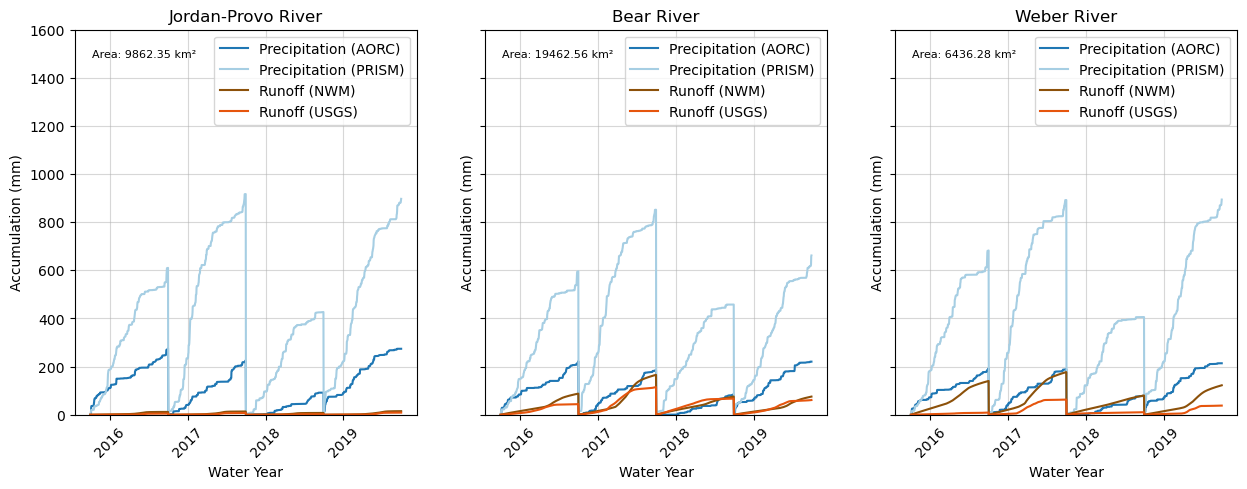

In [31]:
# create a figure and three subplots in one row
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, gridspec_kw={'hspace': 0.5})

# set the areas for each watershed so we can annotate them on the plot
areas = [9862.35, 19462.56, 6436.28]

# set lists of the dataframes to loop through, river names, and line colors as above
merged_dataframes = [merged_jordan, merged_bear, merged_weber]
locations = ['Jordan-Provo River', 'Bear River', 'Weber River']
line_colors = ['#1f77b4', '#a6cee3', '#8c510a', '#e6550d']  

# for each dataframe/subplot pair
for idx, ax in enumerate(axs):
    
    # get the dataframe and river name from the lists
    df = merged_dataframes[idx]
    location = locations[idx]
    
    # plot the cumulative values for all the datasets agains the Date variable
    ax.plot(df['Date'], df['cum_precip_mm_AORC'], label='Precipitation (AORC)', color=line_colors[0])
    ax.plot(df['Date'], df['cum_precip_mm_PRISM'], label='Precipitation (PRISM)', color=line_colors[1])
    ax.plot(df['Date'], df['cum_runoff_mm_NWM'], label='Runoff (NWM)', color=line_colors[2])
    ax.plot(df['Date'], df['cum_runoff_mm_USGS'], label='Runoff (USGS)', color=line_colors[3])
    
    # set subplot title, labels, and configurations
    ax.set_title(location)
    ax.set_xlabel('Water Year')
    ax.set_ylabel('Accumulation (mm)')
    ax.set_ylim(0, 1600)
    ax.legend()
    ax.grid(alpha=0.5)
    
    # format x-axis ticks to show only years
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_tick_params(rotation=45)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    
    # set custom x-axis tick labels
    ax.set_xticklabels(['2015', '2016', '2017', '2018', '2019', '2020'])
    
    # annotate the plot with the river basin area
    ax.text(0.05, 0.95, f'Area: {areas[idx]} km²', transform=ax.transAxes, horizontalalignment='left', verticalalignment='top', fontsize=8, color='black')

# show the plots
plt.show()

And that's it! We've completed Analysis III.

<div class="alert alert-block alert-success"><b> Delving deeper: We assumed that the PRISM daily values and the AORC daily values would be pretty different based on our comparisons of the PRISM monthly normals and the AORC daily values in Analysis I. Analysis III confirms that suspicion. The PRISM values are much higher than the AORC values. The NWM modeled runoff matches the precipitation pretty closely because it doesn't incorporate human use; it appears the main driver of the modeled runoff is the precipitation, so if this dataset isn't robust, the NWM modeled runoff (even without human use) might be less credible. This highlights the need for further benchmarking of the NWM before it can be used for water supply prediction. </b></div>